In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pygmo import hypervolume
import pygmo as pg
'hypervolume' in dir()
plt.close("all")

In [2]:
start_time = 1
end_time = 1000

In [3]:
def get_deviation_times(path):
    with open(path) as f:
        f_csv = csv.reader(f)
        first_line = next(f_csv)  # read first line
        _dev_list = list(map(int, first_line))
    return _dev_list

def calc_mean_utility(path, deviation_times: list):
    df = pd.read_csv(path,header=None, names=["time","distance"])
    # treat the utility deviation at any update time as 0
    df.at[df["time"].isin(deviation_times), 'distance'] = 0
    return df["distance"].mean()

def calc_mean_position(path, deviation_times: list):
    df = pd.read_csv(path,header=None, names=["time","distance"])
    # treat the position deviation at any update time as 0
    df.at[df["time"].isin(deviation_times), 'distance'] = 0
    return df["distance"].mean()

In [4]:
def parse_config(my_string):
    config = my_string.replace(".txt","").split("-")
    # example: ['seed3333', 'compare_action', 'threshold0.1_0', 'human_seed100']
    seed = "null"
    compare = "null"
    threshold = "null"
    human_seed = "null"
    for c in config:
        if "seed" in c and "human_seed" not in c:
            seed = c.replace("seed", "")
        if "compare" in c:
            compare = c.replace("compare_","")
        if "threshold" in c:
            threshold = c.replace("threshold","").split("_")[0]
        if "human_seed" in c:
            human_seed = c.replace("human_seed", "")
    return dict(compare=compare,threshold=threshold,seed=seed,human_seed=human_seed)

import os
def parse_statistics(directory: str, position=False):
    """
    The directory tree should be like:
        - directory/
        |---2021-12-12--23-26-49/
           |---statistics/
              |---deviation_record.csv
              |---distances_utility.csv
           |---trace/
              |---seed3333-compare_action-threshold0.1_0-human_seed100.txt
        |---2021-12-12--23-27-06
        |---2021-12-12--23-27-23
        |---...
        
    :param directory: the root directory
    """
    subdirs = sorted([f.path for f in os.scandir(directory) if f.is_dir()])

    dicts = []
    for subdir in subdirs:
        path_times = os.path.join(subdir, "statistics", "deviation_record.csv")
        path_util = os.path.join(subdir, "statistics", "distances_utility.csv")
        
        deviation_times = get_deviation_times(path_times)
        mean_utility = calc_mean_utility(path_util, deviation_times)
        if position is True:
            path_pos = os.path.join(subdir, "statistics", "distances_position.csv")
            mean_pos = calc_mean_position(path_pos, deviation_times)
        
        # get the configuration
        config_path = [f.name for f in os.scandir(os.path.join(subdir, "trace")) if f.is_file() and "seed" in f.name]
        assert(len(config_path)==1)
        #ppppp = os.path.join(subdir, "trace", config_path[0])
        #os.rename(ppppp, ppppp.replace("3333","1111"))

        data_row = parse_config(config_path[0])
        data_row["updates"] = len(deviation_times)
        data_row["utility"] = mean_utility
        if position is True:
            data_row["position"] = mean_pos
        dicts.append(data_row)
    return pd.DataFrame(dicts)

In [5]:
def concat_all_statistics(base_dir, csv_name):
    """
    Concatenate all the statistics files inside all the primary subdirectories of base_dir
    
    - base_dir
    |---position/
        |---dir1/
            |---csv_name 
        |---dir2/
            |---csv_name 
    |---action/
        |---dir1/
            |---csv_name 
        |---dir2/
            |---csv_name
    |---interaction/
        |---dir1/
            |---csv_name  
    """
    frames = []
    for entry in os.scandir(base_dir):
        if entry.is_dir():
            for sub_entry in os.scandir(entry.path):
                if sub_entry.is_dir():
                    try:
                        frames.append(pd.read_csv(os.path.join(sub_entry, csv_name), index_col=0))
                    except Exception as e:
                        print(str(e))

    df = pd.concat(frames, ignore_index=True)
    return df.sort_values(by=["compare", "seed", "threshold", "human_seed"]).reset_index(drop=True)

In [6]:
scenario = "new_random3-D"

for seed in [1111,2222, 4444, 5555, 6666]:
    directory = "./output/{}/position-s{}/0".format(scenario,seed)
    df = parse_statistics(directory)
    df.to_csv(os.path.join(directory, "statistics_raw.csv"))
    
    directory = "./output/{}/interaction-s{}/0".format(scenario,seed)
    df = parse_statistics(directory)
    df.to_csv(os.path.join(directory, "statistics_raw.csv"))
    
    directory = "./output/{}/action_direct-s{}/0".format(scenario,seed)
    df = parse_statistics(directory)
    df["compare"] = "action_direct"
    df.to_csv(os.path.join(directory, "statistics_raw.csv"))
    
    directory = "./output/{}/action_direct_v2-s{}/0".format(scenario,seed)
    df = parse_statistics(directory)
    df["compare"] = "action_direct_v2"
    df.to_csv(os.path.join(directory, "statistics_raw.csv"))

    
base_dir = "./output/{}/".format(scenario)
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))

FileNotFoundError: [Errno 2] No such file or directory: './output/new_random3-D/interaction-s1111/0'

In [66]:
directory = "./output/no_updates/r3-U"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

In [7]:
directory = "./output/new_designed3-D/position_all/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

base_dir = "./output/new_designed3-D/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))

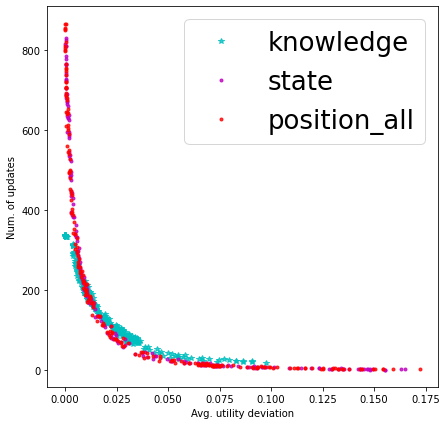

In [10]:
my_plot(df, "new_designed3-D", ["position","position_all","interaction"])

In [222]:
directory = "./output/new_designed1-U/position/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/new_designed1-U/position_all/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

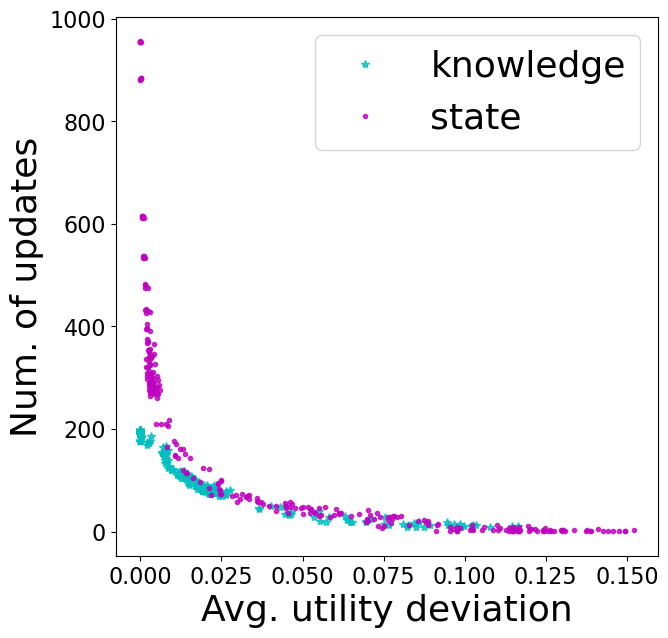

In [315]:
base_dir = "./output/new_designed1-U/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))

my_plot(df, "new_designed1-U", ["position","interaction"])

In [333]:
directory = "./output/new_designed2-U/position/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/new_designed2-U/interaction/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

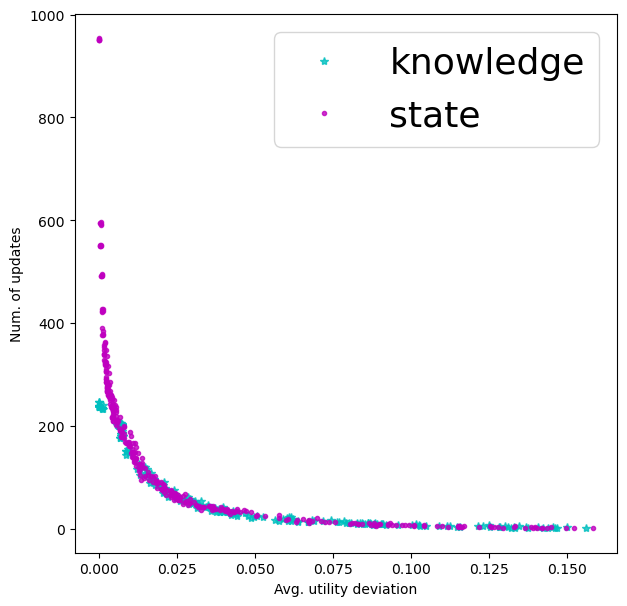

In [334]:
base_dir = "./output/new_designed2-U/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))

my_plot(df, "new_designed2-U", ["interaction", "position"])

In [318]:
directory = "./output/new_designed3-U/interaction/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/new_designed3-U/position/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

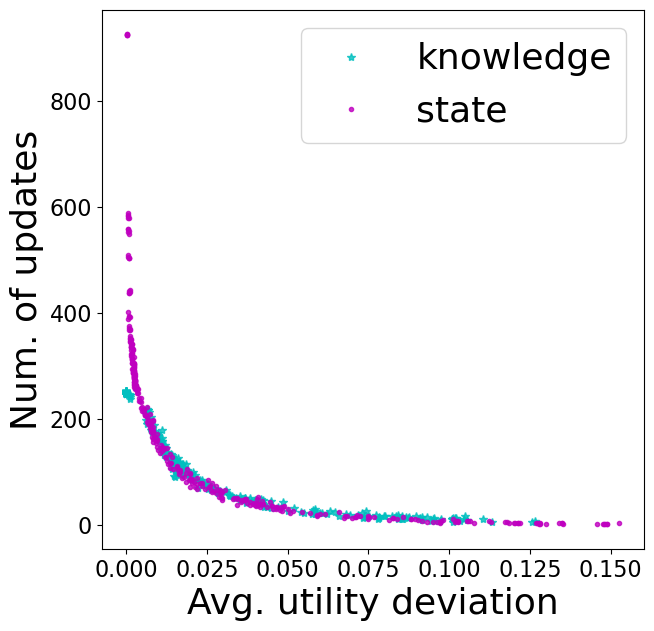

In [319]:
base_dir = "./output/new_designed3-U/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))

my_plot(df, "new_designed3-U", ["position","interaction"])

In [310]:
directory = "./output/new_random1-U/position/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/new_random1-U/interaction/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

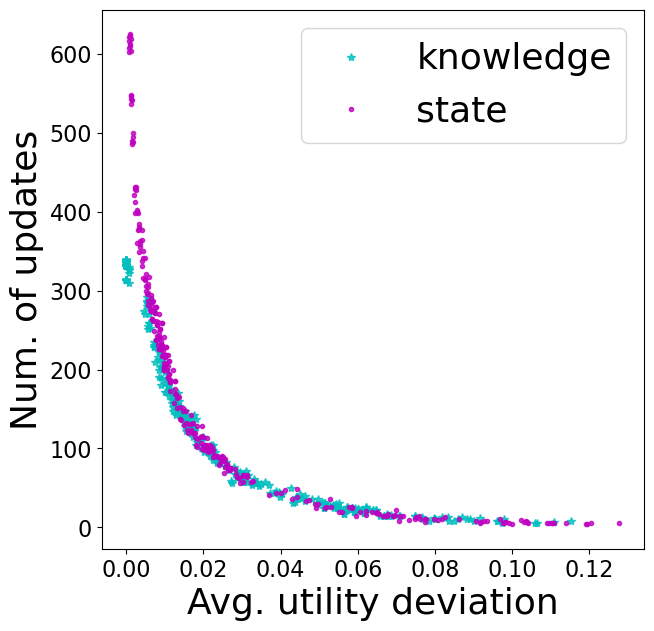

In [311]:
base_dir = "./output/new_random1-U/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))

my_plot(df, "new_random1-U", [ "position","interaction"])

In [304]:
directory = "./output/new_random2-U/interaction_5/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/new_random2-U/position_5/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))


[Errno 2] No such file or directory: './output/new_random2-U/position_2/0/statistics_raw.csv'
[Errno 2] No such file or directory: './output/new_random2-U/position_all/0/statistics_raw.csv'
[Errno 2] No such file or directory: './output/new_random2-U/interaction_2/0/statistics_raw.csv'


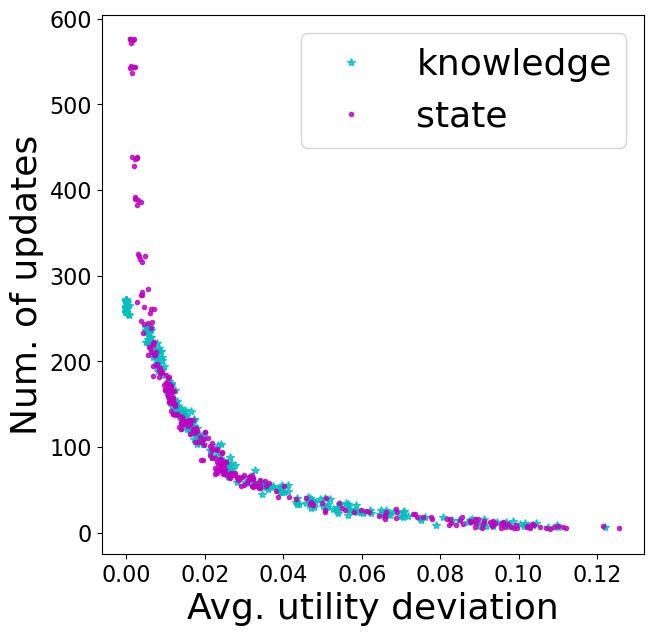

In [305]:
base_dir = "./output/new_random2-U/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))

my_plot(df, "new_random2-U", ["position_all","position","interaction"])

In [281]:
directory = "./output/new_random3-U/position/0"
df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/new_random3-U/interaction/0"
df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

base_dir = "./output/new_random3-U/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))


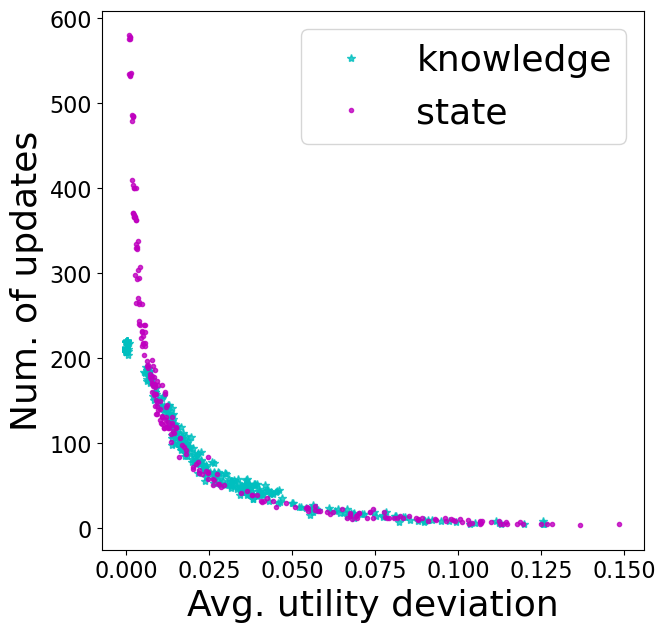

In [282]:
#my_plot(df, "new_random3-U", ["position","position_all","interaction"])
my_plot(df, "new_random3-U", ["position","interaction"])

In [271]:
directory = "./output/new_random3-U-uncertainty2/interaction/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/new_random3-U-uncertainty2/position/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

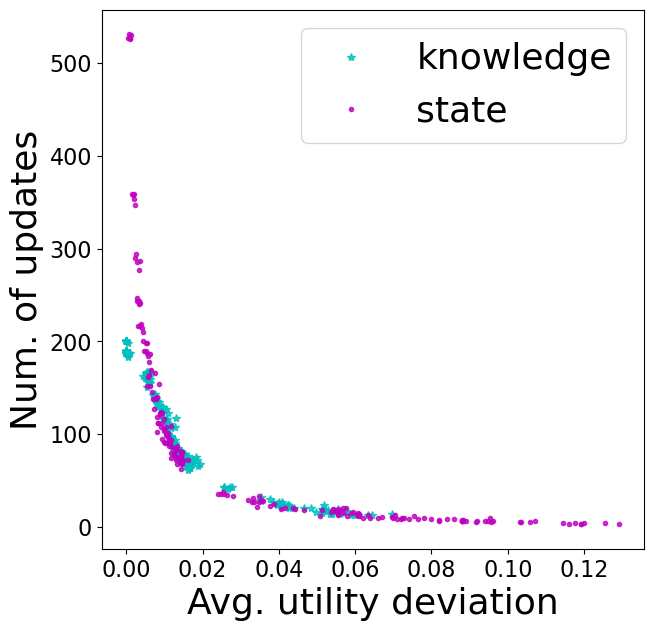

In [272]:
base_dir = "./output/new_random3-U-uncertainty2/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))

my_plot(df, "new_random3-U", ["position","interaction"])

new_designed1-U
Figure saved to fig/new_designed1-U.pdf


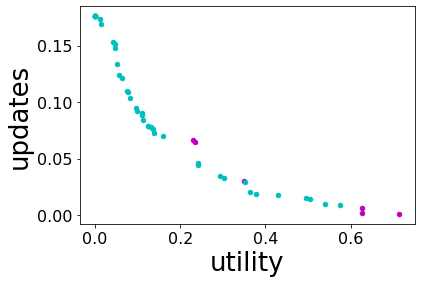

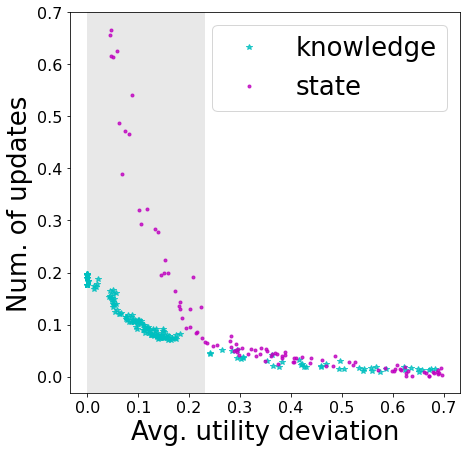

interaction		: 0.9635013168290756
position_all		: 0.9012557282064787
new_designed2-U
Figure saved to fig/new_designed2-U.pdf


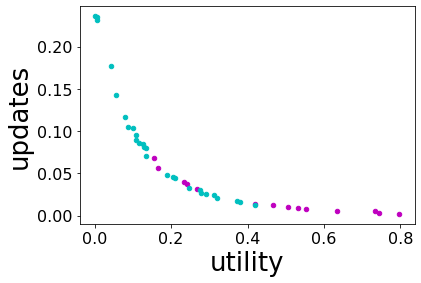

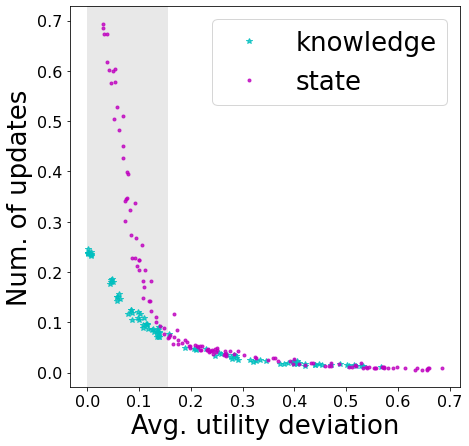

interaction		: 0.9614901843704022
position_all		: 0.9229738387937136
new_designed3-U
Figure saved to fig/new_designed3-U.pdf


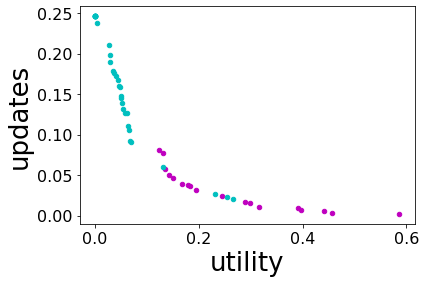

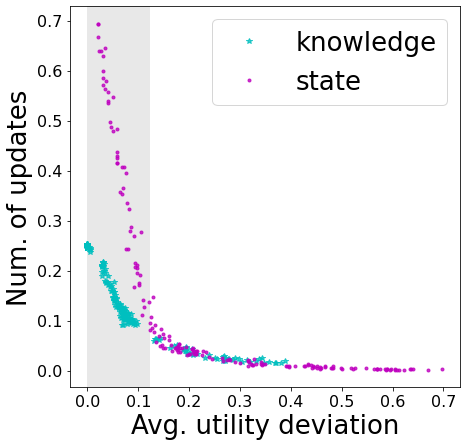

interaction		: 0.9640415786666945
position		: 0.9725524757428593
position_all		: 0.9355034150231059
new_random1-U
Figure saved to fig/new_random1-U.pdf


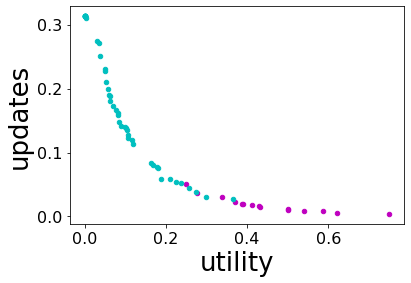

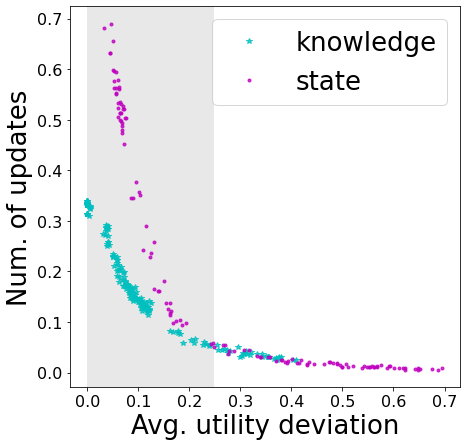

interaction		: 0.944602347255782
position_all		: 0.906897134967208
new_random2-U
Figure saved to fig/new_random2-U.pdf


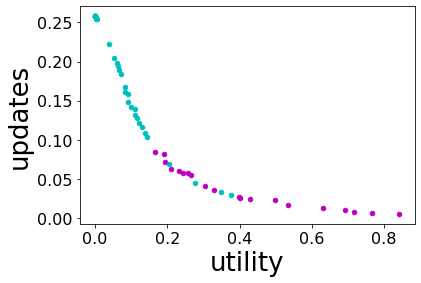

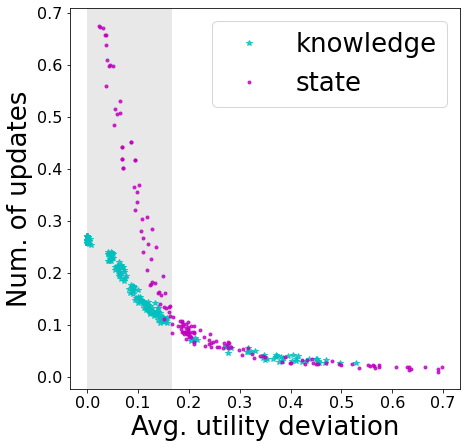

interaction		: 0.9411537168920542
position_all		: 0.9114351444346651
new_random3-U
Figure saved to fig/new_random3-U.pdf


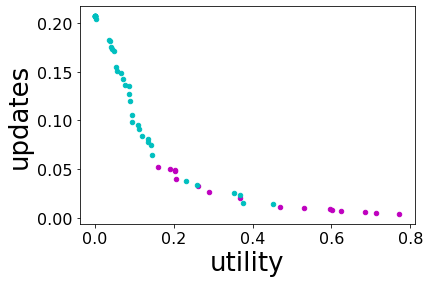

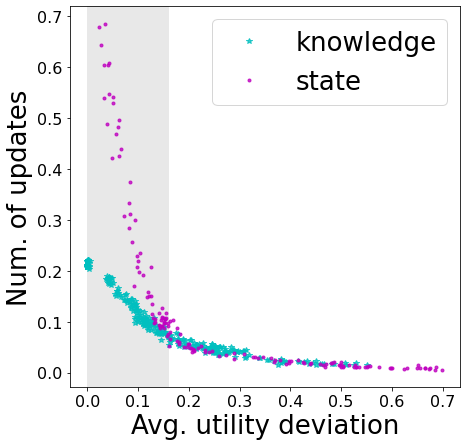

interaction		: 0.9613558357055715
position		: 0.9552682662328862
position_all		: 0.9294350006777827


In [76]:
front_list = []

entry_list = [entry for entry in os.scandir("./output/") if entry.name[-1] == "U"]
entry_list.sort(key=lambda x: x.name)
for entry in entry_list:
    if entry.is_dir:
        stat_path = os.path.join(entry.path, "statistics_all.csv")
        if os.path.isfile(stat_path):
            print(entry.name)
            df = pd.read_csv(stat_path, index_col=0)
            df['updates']=df['updates']/1000
            df['utility']=df['utility']/max_util[entry.name]
            

            # plot the pareto front
            df_tmp = df[(df["compare"]=="interaction") | (df["compare"]=="position_all")]
            front_idx = pg.non_dominated_front_2d(df_tmp[['utility','updates']])
            front = df_tmp.iloc[front_idx,:]
            front_list.append(front)
            ax = front.where(front["compare"]=="position_all").plot.scatter(x='utility',y='updates',color='m')
            front.where(front["compare"]=="interaction").plot.scatter(x='utility',y='updates',ax=ax,color='c')
            
            fill_max = min(front[front['compare']=='position_all']['utility'])
            
            my_plot(df.where(df['utility']<0.7).where(df['updates']<0.7), 
                    entry.name, ["position_all", "interaction"], 
                    range_fill=[0,fill_max],
                    save_fig=True)
                        
            # calculate hypervolume
            calc_hypervolumes(df, ref_point=[1,1])
            

In [320]:
directory = "./output/new_random1-D/interaction-s{}/0".format(seed)

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))


In [321]:
directory = "./output/new_random1-D/position-s{}/0".format(seed)

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))


In [322]:
directory = "./output/new_random1-D/action_direct-s{}/0".format(seed)

df = parse_statistics(directory)
df["compare"] = "action_direct"
df.to_csv(os.path.join(directory, "statistics_raw.csv"))


In [323]:

directory = "./output/new_random1-D/action_direct_v2-s{}/0".format(seed)

df = parse_statistics(directory)
df["compare"] = "action_direct_v2"
df.to_csv(os.path.join(directory, "statistics_raw.csv"))


In [146]:
def my_plot(df, title, compare_list, range_fill=None, save_fig=False, label_names=None, params=None):
    # Figure formatting
    style = dict(position='m.', interaction='c*', action='y^', action_direct='g^', action_new='b^', action_direct_v2='y^', action_v2='r^', position_all='r.', s_s='k+', s_s_keep='g.', k_s="b*", k_s_keep="y.")
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    if params is not None:
        #params = {'legend.fontsize': '26',
        #         'axes.labelsize': '26',
        #         'xtick.labelsize':'16',
        #         'ytick.labelsize':'16'}
        plt.rcParams.update(params)
        
    plt.xlabel('Avg. utility deviation')
    plt.ylabel('No. of updates')
    plt.xlim([-0.02, 0.62])
    plt.ylim([-0.02, 0.62])
    #plt.title(title)
    if range_fill is not None:
        plt.axvspan(range_fill[0],range_fill[1], facecolor="lightgrey",alpha=0.5)
        #ax.fill_between(range_fill, 0, 0.6, alpha=0.2, transform=ax.get_xaxis_transform())


    i = 0
    grouped = df.groupby('compare')
    for name, group in grouped:
        if name in compare_list:
            display_name=name
            if name=="interaction":
                display_name = "knowledge"
            if name=="position":
                display_name = "state"
            if name=="position_all":
                display_name = "state"
            if name=="action_direct_v2":
                display_name = "action"
            if name=="action_direct":
                display_name = "action2"
            if label_names is not None:
                display_name = label_names[i]
            i = i+1
            ax.plot(group["utility"], group["updates"], style[name], label=display_name,alpha=0.8, markersize=3.5)
            ax.legend()
    
    if save_fig is True:
        plt.savefig('fig/{}.pdf'.format(title),bbox_inches = "tight") 
        print("Figure saved to fig/{}.pdf".format(title))
    plt.show()

In [120]:
def calc_hypervolumes(df, ref_point=[1,1]):
    """
    df needs to be scaled before passing into this function
    """
    
    grouped = df.groupby('compare')
    for name, group in grouped:        
        # Get Pareto front
        front_idx = pg.non_dominated_front_2d(group[['utility','updates']])
        front = group.iloc[front_idx,:]

        # remove outliers
        group_filtered = group[group["utility"] < ref_point[0]]
        hv_i = hypervolume(np.array([group_filtered["utility"], group_filtered["updates"]]).T)
        print("{}\t\t: {}".format(name, hv_i.compute(ref_point)))

calc_hypervolumes(df)


position		: 0.9763515
s_s		: 0.9758416
s_s_keep		: 0.9761952


In [123]:

max_util = {"new_designed1-D":0.14357,
            "new_designed2-D":0.145233282,
            "new_designed3-D":0.22239997,
            "new_random1-D":0.134335,
            "new_random2-D":0.11645,
            "new_random3-D":0.14155,
            "new_designed1-U":0.15188,
            "new_designed2-U":0.151866621,
            "new_designed3-U":0.216683307,
            "new_random1-U":0.14485,
            "new_random2-U":0.12497,
            "new_random3-U":0.14754,
           }

range_fill = {"new_designed1-D":[0,0.165773],
              "new_designed2-D":[0,0.056231],
              "new_designed3-D":[0,0.064074],
              "new_random1-D":[0,0.177541],
              "new_random2-D":[0,0.198368],
              "new_random3-D":[0,0.091840],
           }

new_designed1-D
action		: 0.7443219335515776
action_direct		: 0.904416451904994
action_direct_v2		: 0.912788813819043
action_v2		: 0.36026119662882217
interaction		: 0.9639338301873651
position		: 0.9534041234241143
s_s		: 0.9484379048547757


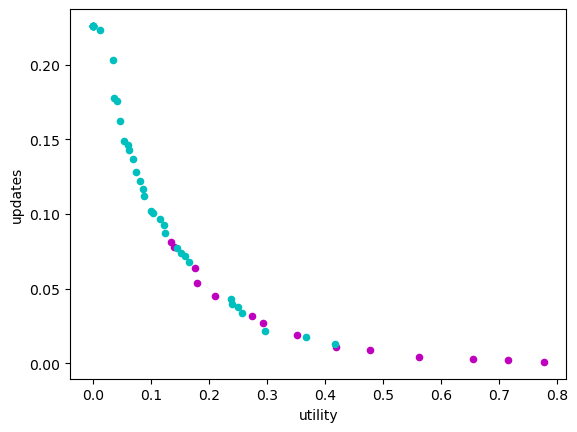

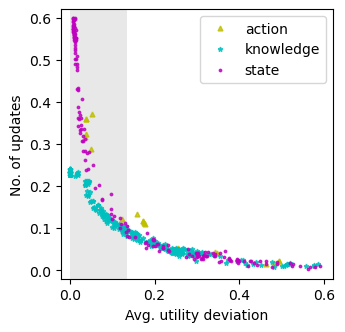

Figure saved to fig/new_designed1-D-action.pdf


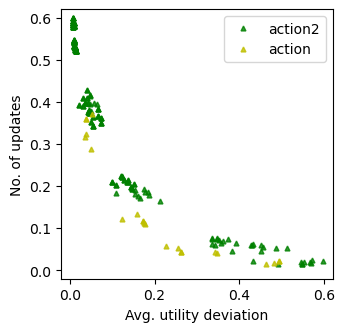

new_designed2-D
action_direct		: 0.8858780626605958
action_direct_v2		: 0.8926948644939388
interaction		: 0.9500164840177612
position		: 0.9497305398083618


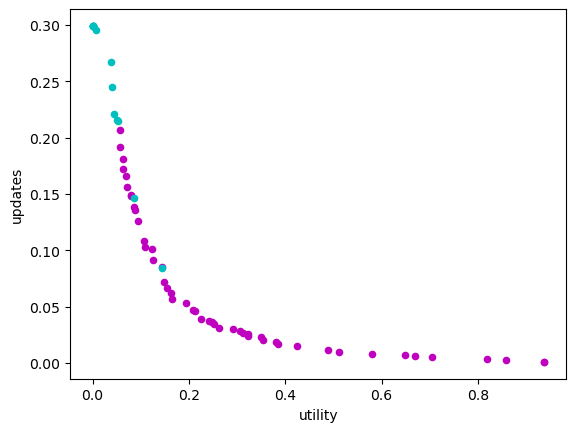

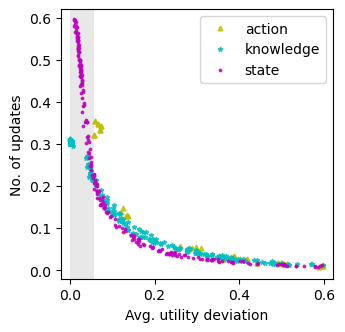

Figure saved to fig/new_designed2-D-action.pdf


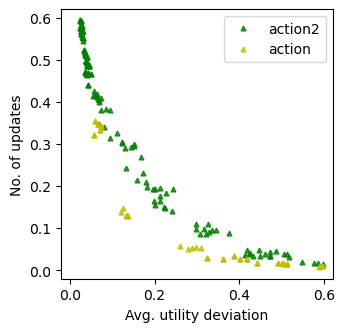

new_designed3-D
action_direct		: 0.9192319727291329
action_direct_v2		: 0.9341825358025002
interaction		: 0.9643054349467765
position		: 0.9654726439981086
position_all		: 0.9665762080858198


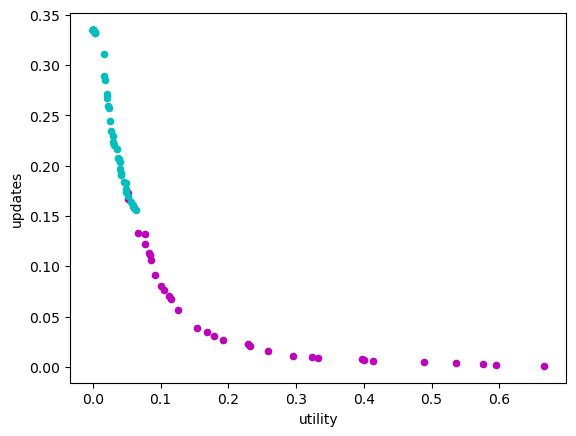

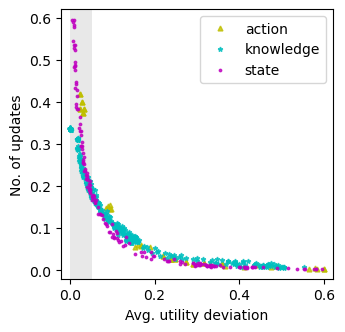

Figure saved to fig/new_designed3-D-action.pdf


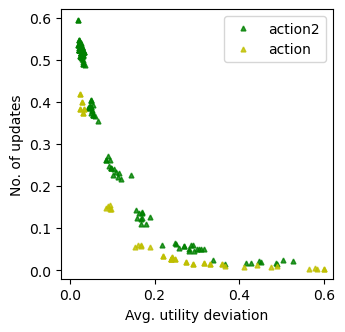

new_random1-D
action_direct		: 0.9037418766516543
action_direct_v2		: 0.9033626009602864
interaction		: 0.9489274202553317
k_s		: 0.7296938251386464
k_s_keep		: 0.9250152231361899
position		: 0.9443042394014967
s_s		: 0.9426352774779473
s_s_keep		: 0.7571955558864036


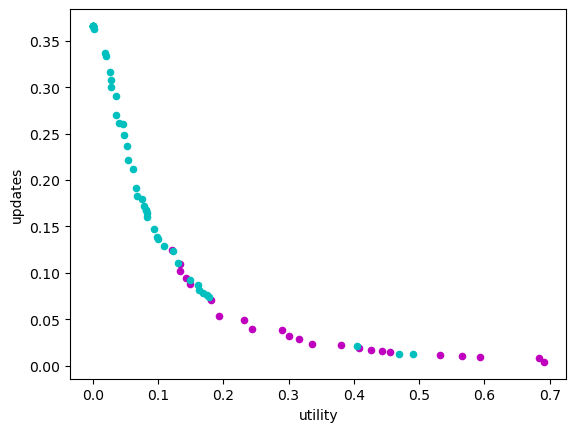

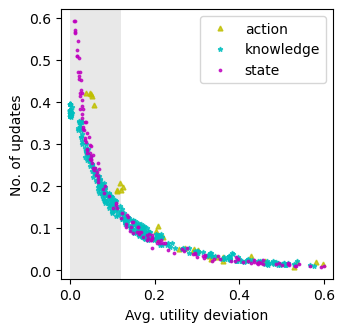

Figure saved to fig/new_random1-D-action.pdf


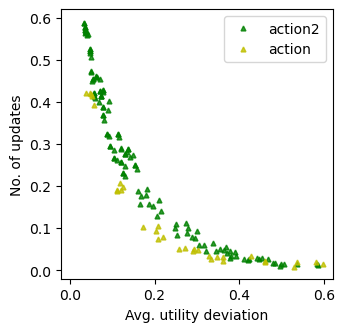

new_random2-D
action_direct		: 0.8542490339201375
action_direct_v2		: 0.8454873336195792
interaction		: 0.9412662086732504
position		: 0.9306891369686559
s_s		: 0.926644482610563


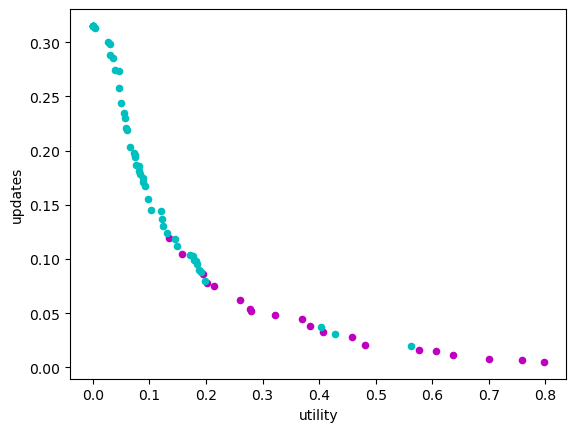

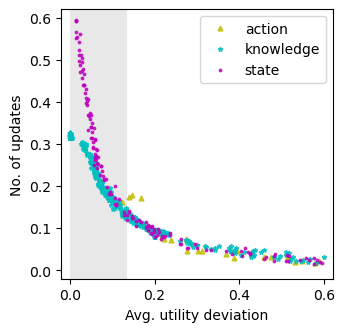

Figure saved to fig/new_random2-D-action.pdf


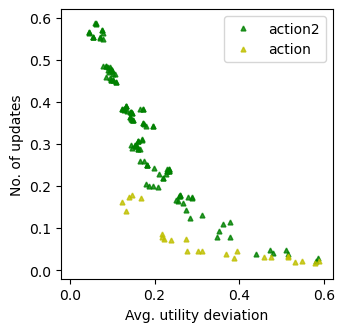

new_random3-D
action_direct		: 0.9115450370893683
action_direct_v2		: 0.9129600847756977
interaction		: 0.9715941363475804
position		: 0.9648505828329215


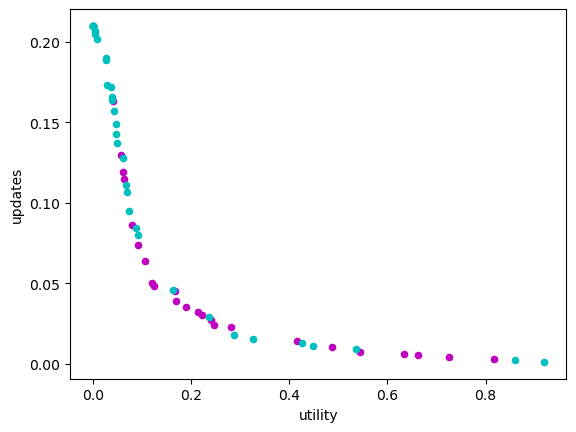

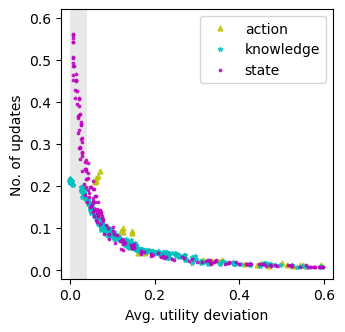

Figure saved to fig/new_random3-D-action.pdf


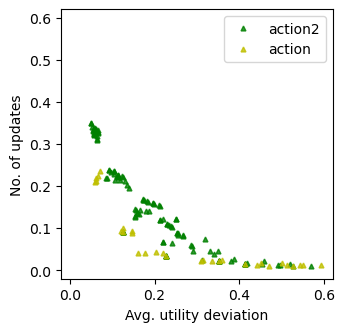

In [147]:
plt.rcParams.update(plt.rcParamsDefault)


front_list = []

entry_list = [entry for entry in os.scandir("./output/")  if entry.name[-1] == "D"]
entry_list.sort(key=lambda x: x.name)
for entry in entry_list:
    if entry.is_dir:
        stat_path = os.path.join(entry.path, "statistics_all.csv")
        if os.path.isfile(stat_path) and entry.name[:3]=="new":
            print(entry.name)
            df = pd.read_csv(stat_path, index_col=0)
            df['updates']=df['updates']/1000
            df['utility']=df['utility']/max_util[entry.name]
            
            # calculate hypervolume
            calc_hypervolumes(df, ref_point=[1,1])

            # plot the pareto front
            df_tmp = df[(df["compare"]=="interaction") | (df["compare"]=="position")]
            front_idx = pg.non_dominated_front_2d(df_tmp[['utility','updates']])
            front = df_tmp.iloc[front_idx,:]
            front_list.append(front)
            ax = front.where(front["compare"]=="position").plot.scatter(x='utility',y='updates',color='m')
            front.where(front["compare"]=="interaction").plot.scatter(x='utility',y='updates',ax=ax,color='c')
            
            fill_max = min(front[front['compare']=='position']['utility'])
            

            my_plot(df.where(df['utility']<0.6).where(df['updates']<0.6), 
                    entry.name, ["interaction", "position", "action_direct_v2"], 
                    range_fill=[0, fill_max],
                    save_fig=False)
            
            my_plot(df.where(df['utility']<0.6).where(df['updates']<0.6), entry.name+"-action", ["action_direct_v2", "action_direct"], save_fig=True)
            
      

In [353]:
directory = "./output/new_random3-D/interaction/0"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

base_dir = "./output/new_random3-D/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))

./output/new_designed1-D
action		: 0.7362672563906109
action_direct		: 0.9029568851431355
action_direct_v2		: 0.9089973532074946
interaction		: 0.9628813122518632
position		: 0.9503268092219821
s_s		: 0.9442133454064223
./output/new_designed2-D
action_direct		: 0.8840958718539461
action_direct_v2		: 0.8910421208893426
interaction		: 0.9500164840177612
position		: 0.9455977745927413
./output/new_designed3-D
action_direct		: 0.9141057132966338
action_direct_v2		: 0.9336083451495069
interaction		: 0.9643054349467765
position		: 0.9637697115651591
position_all		: 0.9650238309924234
./output/new_random1-D
action_direct		: 0.8939611047009343
action_direct_v2		: 0.9012981352588683
interaction		: 0.9489274202553317
k_s		: 0.693390627907843
k_s_keep		: 0.919564521531991
position		: 0.9401383481594523
s_s		: 0.93800573193881
s_s_keep		: 0.7545663081103214
./output/new_random2-D
action_direct		: 0.849264920566767
action_direct_v2		: 0.8417483898668956
interaction		: 0.9385358522971232
position		:

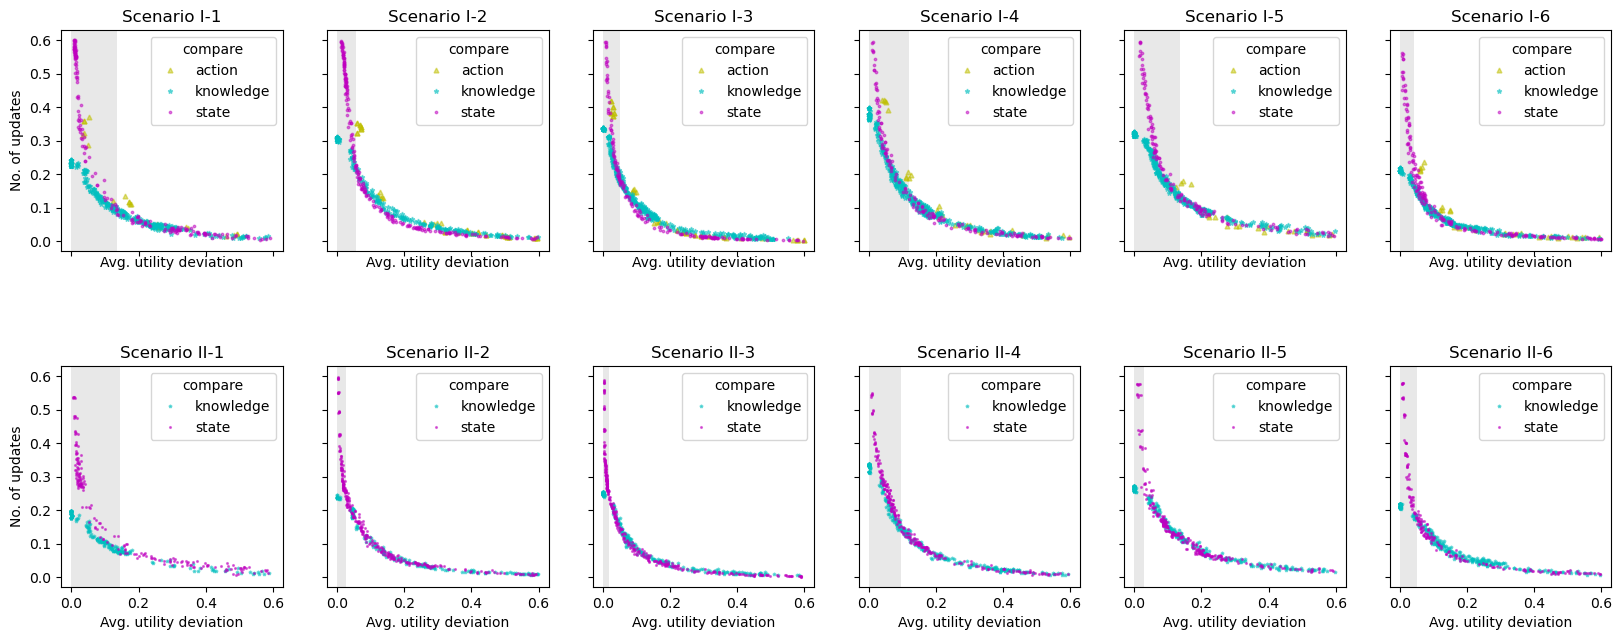

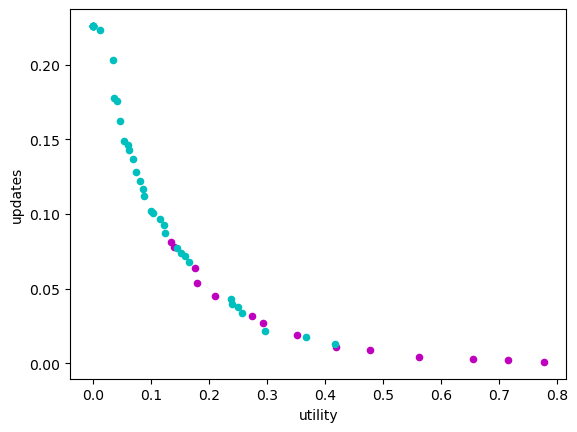

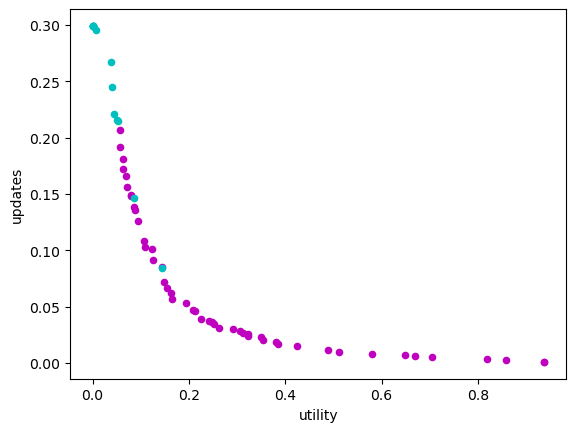

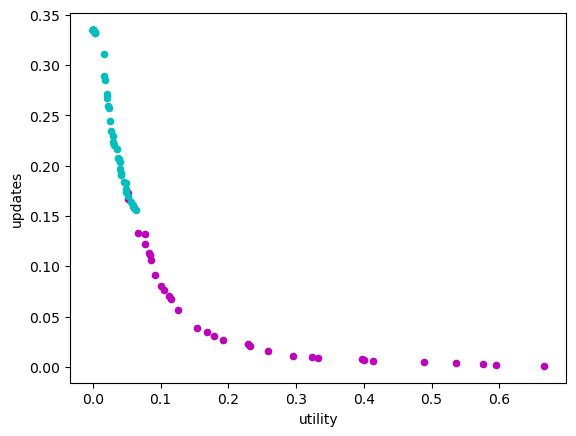

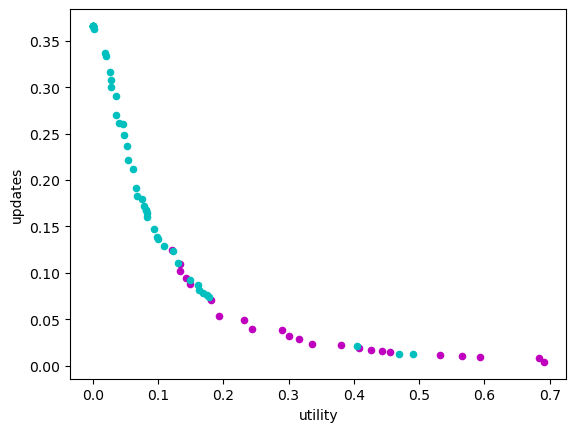

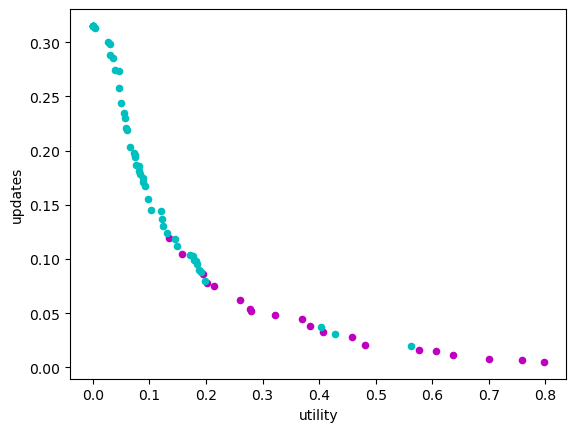

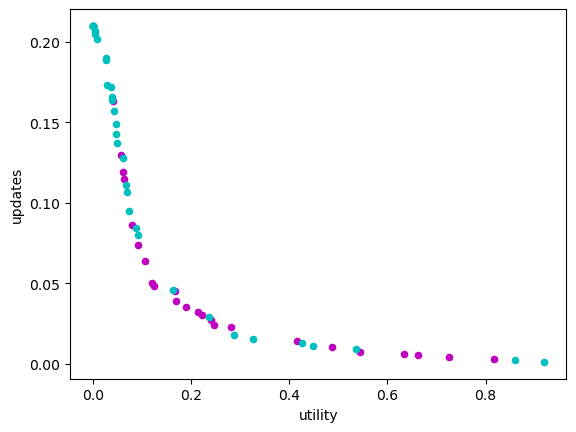

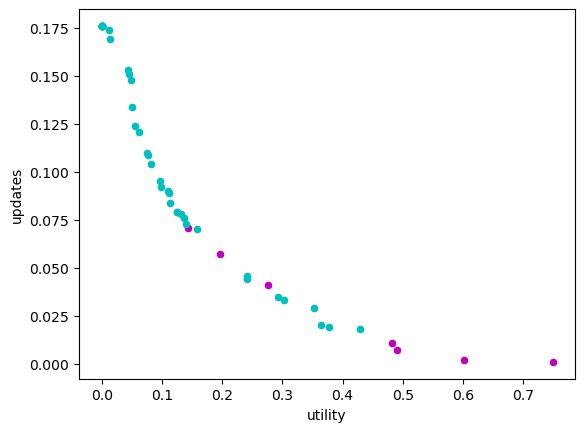

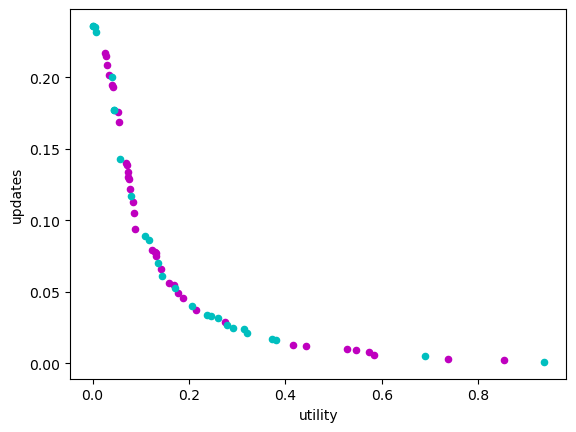

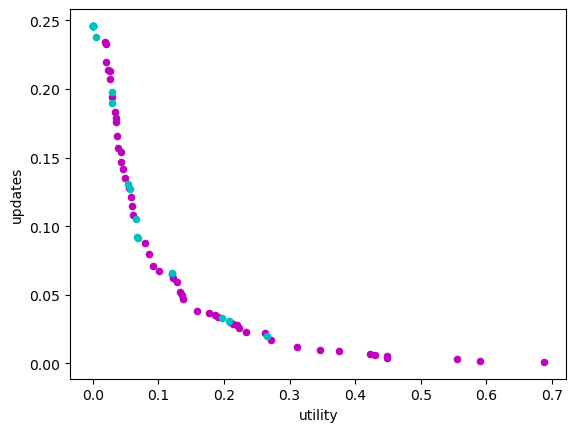

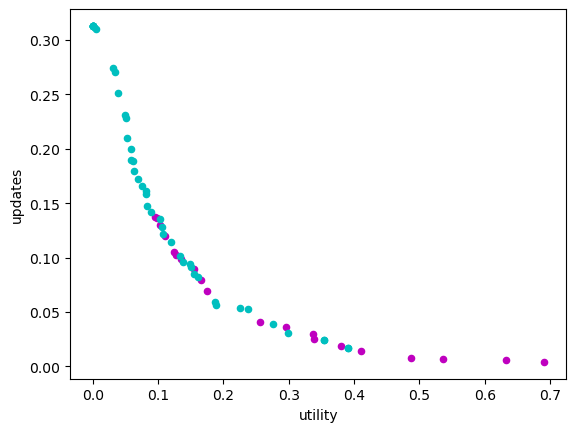

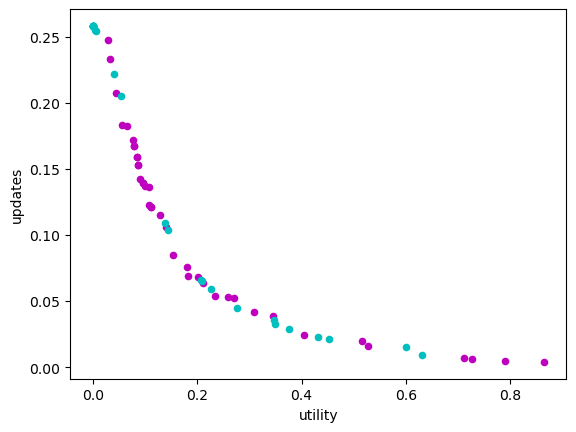

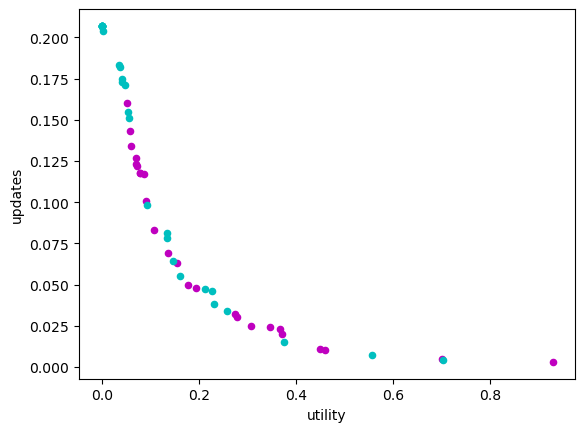

In [364]:
##### Beautifying Figure Plotting

scenarios = ["designed1-D", "designed2-D", "designed3-D", 
            "random1-D", "random2-D", "random3-D",
            "designed1-U", "designed2-U", "designed3-U", 
            "random1-U", "random2-U", "random3-U"]
style = dict(position='m.', interaction='c*', 
             action='y^', action_direct='g^', action_new='b^', action_direct_v2='y^', action_v2='r^', 
             position_all='m.', s_s='k+', s_s_keep='g.', k_s="b*", k_s_keep="y.")

legend = dict(interaction="knowledge", 
              position="state", 
              position_all="state",
              action_direct_v2="action")
plt.rcParams.update(plt.rcParamsDefault)



figure1, axes1 = plt.subplots(2, 6, figsize=(20,8), sharex=True, sharey=True)


front_list = []
i = 0
for scenario in scenarios:
    scenario_name = "new_{}".format(scenario) 
    sce_path = "./output/new_{}".format(scenario) 

    stat_path = os.path.join(sce_path, "statistics_all.csv")
    if os.path.isfile(stat_path):
        print(sce_path)
        df = pd.read_csv(stat_path, index_col=0)
        df['updates']=df['updates']/1000
        df['utility']=df['utility']/max_util[scenario_name]

        # calculate hypervolume
        #calc_hypervolumes(df, ref_point=[1,1])
        calc_hypervolumes(df[(df['utility']<0.6) & (df['updates']<0.6)], ref_point=[1,1])
        
        # scenarios with "-D"
        if scenario[-1] == "D":
            # plot the pareto front
            df_tmp = df[(df["compare"]=="interaction") | (df["compare"]=="position")]
            front_idx = pg.non_dominated_front_2d(df_tmp[['utility','updates']])
            front = df_tmp.iloc[front_idx,:]
            front_list.append(front)
            ax = front.where(front["compare"]=="position").plot.scatter(x='utility',y='updates',color='m')
            front.where(front["compare"]=="interaction").plot.scatter(x='utility',y='updates',ax=ax,color='c')


            fill_max = min(front[front['compare']=='position']['utility'])

            df_filtered = df[(df['utility']<0.6) & (df['updates']<0.6)]
            for name, group in df_filtered.groupby('compare'):
                if name in ["interaction", "position", "action_direct_v2"]:
                    axes1[0,i].plot(group["utility"], group["updates"], style[name], label=legend[name],alpha=0.5, markersize=3.5)
            axes1[0,i].set_aspect('equal')
            axes1[0,i].axvspan(0,fill_max, facecolor="lightgrey",alpha=0.5)
            axes1[0,i].legend(title="compare")
            if i == 0:
                axes1[0,i].set_ylabel("No. of updates")
            axes1[0,i].set_xlabel("Avg. utility deviation")
            axes1[0,i].set_title("Scenario I-{}".format(i+1))
        
        elif scenario[-1] == "U":
            # plot the pareto front
            df_tmp = df[(df["compare"]=="interaction") | (df["compare"]=="position")]
            front_idx = pg.non_dominated_front_2d(df_tmp[['utility','updates']])
            front = df_tmp.iloc[front_idx,:]
            front_list.append(front)
            ax = front.where(front["compare"]=="position").plot.scatter(x='utility',y='updates',color='m')
            front.where(front["compare"]=="interaction").plot.scatter(x='utility',y='updates',ax=ax,color='c')


            fill_max = min(front[front['compare']=='position']['utility'])

            df_filtered = df[(df['utility']<0.6) & (df['updates']<0.6)]
            for name, group in df_filtered.groupby('compare'):
                if name in ["interaction", "position"]:
                    axes1[1,i].plot(group["utility"], group["updates"], style[name], label=legend[name],alpha=0.5, markersize=2.5)
            axes1[1,i].set_aspect('equal')
            axes1[1,i].axvspan(0,fill_max, facecolor="lightgrey",alpha=0.5)
            axes1[1,i].legend(title="compare")
            if i == 0:
                axes1[1,i].set_ylabel("No. of updates")
            axes1[1,i].set_xlabel("Avg. utility deviation")
            axes1[1,i].set_title("Scenario II-{}".format(i+1))
        i = i + 1
        if i == 6:
            i = 0

figure1.savefig('fig/checking.pdf',bbox_inches = "tight")




./output/new_designed1-D


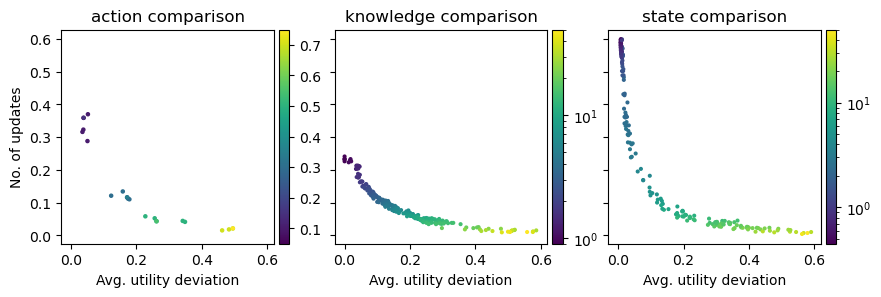

In [356]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

scenario = "designed1-D"
scenario_name = "new_{}".format(scenario) 
sce_path = "./output/new_{}".format(scenario) 
cmap = {
    "interaction":"viridis",
    "position":"viridis",
    "action_direct_v2":"viridis"
}

plt.rcParams.update(plt.rcParamsDefault)


figure, axes = plt.subplots(1, 3, figsize=(10,3.5), sharex=True, sharey=True)


i = 0
stat_path = os.path.join(sce_path, "statistics_all_no_outlier.csv")
if os.path.isfile(stat_path):
    print(sce_path)
    df = pd.read_csv(stat_path, index_col=0)

    df['updates']=df['updates']/1000
    df['utility']=df['utility']/max_util[scenario_name]

    df_filtered = df[(df['utility']<0.6) & (df['updates']<0.6)]
    for name, group in df_filtered.groupby('compare'):
        if name in ["interaction", "position", "action_direct_v2"]:
            if name == "action_direct_v2":
                points = axes[i].scatter(group["utility"], group["updates"], marker=".", c=group["threshold"], s=20,
                                  cmap=cmap[name])
            else:
                points = axes[i].scatter(group["utility"], group["updates"], marker=".", c=group["threshold"], s=15,
                                  cmap=cmap[name], norm=colors.LogNorm(vmin=group["threshold"].min(), vmax=group["threshold"].max()))
            
            # Plot colorbar for each subplot
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(points, cax=cax)
            
            axes[i].set_aspect('equal')
            axes[i].set_xlabel("Avg. utility deviation")
            if i == 0:
                axes[i].set_ylabel("No. of updates")
            if "action" == name[:6]:
                display_name = "action"
            elif name == "interaction":
                display_name = "knowledge"
            elif name == "position":
                display_name = "state"
            else:
                display_name = "???"
            axes[i].set_title("{} comparison".format(display_name))
            i = i + 1
figure.savefig('fig/threshold_d1-D.pdf',bbox_inches = "tight")




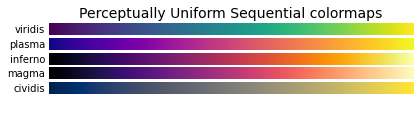

In [25]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

    plot_color_gradients('Perceptually Uniform Sequential',
                     ['viridis', 'plasma', 'inferno', 'magma', 'cividis'])


In [256]:
from src.runner.Loader import TraceLoader
import src.runner.Loader

memory_list = []
scenario_list = ["designed1","designed2","designed3","random1","random2","random3"]
for scenario in scenario_list:
    loader = TraceLoader("./src/simulator/traces_real/test_{}-D-3333.txt".format(scenario))
    traces = loader.read_trace()
    obj_count = src.runner.Loader.get_num_objs(traces[0])
    cam_count = len(traces[0]['cameras'])
    cov_obj_counts = [obj_count - len(state['objects']) for state in traces]
    
    memory = {"action": 999*cam_count*4, # one variable per camera,  int: 4 bytes
             "state": (999*cam_count + sum(cov_obj_counts))*(2*8), 
              # positions of cameras and covered objects, 
              # each entity has two variables {x, y},  double: 8 bytes
             "knowledge": 999*cam_count*(cam_count-1)/2 * 8} 
            # each edge has one variable,  double: 8 bytes
    memory_list.append(memory)
    print('------------')
    print(scenario, "objs", obj_count, "cams", cam_count)
    print("state:\t\t", memory['state'], "bytes")
    print("action:\t\t", memory['action'], "bytes")
    print("knowledge:\t", memory['knowledge'], "bytes")

df_memory = pd.DataFrame(memory_list, index=scenario_list)

------------
designed1 objs 10 cams 5
state:		 156736 bytes
action:		 19980 bytes
knowledge:	 79920.0 bytes
------------
designed2 objs 12 cams 8
state:		 229264 bytes
action:		 31968 bytes
knowledge:	 223776.0 bytes
------------
designed3 objs 12 cams 8
state:		 237216 bytes
action:		 31968 bytes
knowledge:	 223776.0 bytes
------------
random1 objs 20 cams 10
state:		 342704 bytes
action:		 39960 bytes
knowledge:	 359640.0 bytes
------------
random2 objs 10 cams 15
state:		 355536 bytes
action:		 59940 bytes
knowledge:	 839160.0 bytes
------------
random3 objs 10 cams 10
state:		 243056 bytes
action:		 39960 bytes
knowledge:	 359640.0 bytes


action     state  knowledge
Scene 1  0.019054  0.149475   0.076218
Scene 2  0.030487  0.218643   0.213409
Scene 3  0.030487  0.226227   0.213409
Scene 4  0.038109  0.326828   0.342979
Scene 5  0.057163  0.339066   0.800285
Scene 6  0.038109  0.231796   0.342979

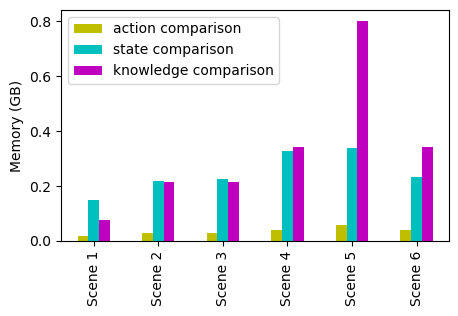

In [258]:
plt.rcParams.update(plt.rcParamsDefault)

df_tmp = df_memory/1024/1024
df_tmp.index=["Scene 1", "Scene 2", "Scene 3", "Scene 4", "Scene 5", "Scene 6"]
fig = df_tmp.plot(ylabel="Memory (GB)",kind='bar', figsize=(5,3), color=['y','c','m']).get_figure()
plt.legend(["action comparison","state comparison","knowledge comparison"])
fig.savefig('fig/{}.pdf'.format("memory"),bbox_inches = "tight")
df_tmp

In [136]:
directory = "./output/new_random1-D/s-s-clear-knowledge/0"
df = parse_statistics(directory)
df["compare"] = "s_s"
df.to_csv(os.path.join(directory, "statistics_raw.csv"))


In [76]:
directory = "./output/new_random1-D/k-s-clear-knowledge/0"
df = parse_statistics(directory)
df["compare"] = "k_s"
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

In [92]:
directory = "./output/new_random1-D/k-s-keep-knowledge/0"
df = parse_statistics(directory)
df["compare"] = "k_s_keep"
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

In [137]:
base_dir = "./output/new_random1-D/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df.to_csv(os.path.join(base_dir, out_file_name))


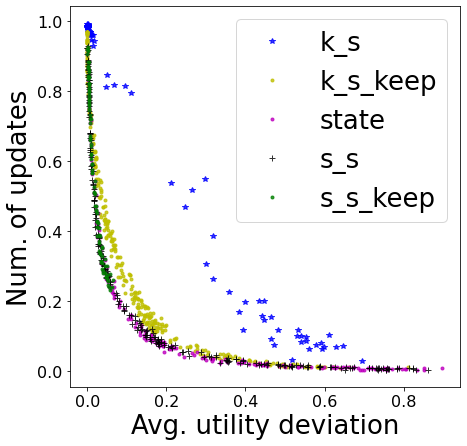

Figure saved to fig/r1-D-update-K-or-not.pdf


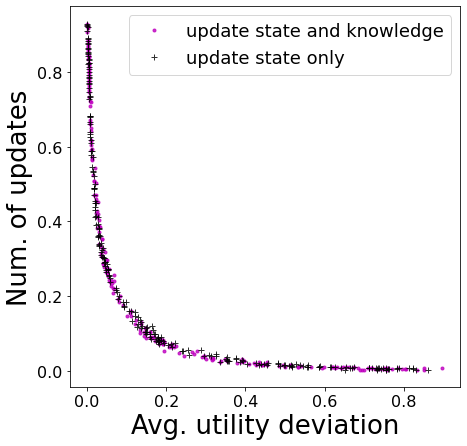

In [16]:

df = pd.read_csv("./output/new_random1-D/statistics_all.csv", index_col=0)
df['updates']=df['updates']/1000
df['utility']=df['utility']/max_util["new_random1-D"]

my_plot(df, 
        "entry.name", ["position", "s_s", "s_s_keep", "k_s", "k_s_keep"],
        save_fig=False)

my_plot(df, 
        "r1-D-update-K-or-not", ["position", "s_s"],
        label_names = ["update state and knowledge","update state only"],
        save_fig=True,
        params = {'legend.fontsize': '18',
             'axes.labelsize': '26',
             'xtick.labelsize':'16',
             'ytick.labelsize':'16'}
       )


<AxesSubplot:xlabel='threshold'>

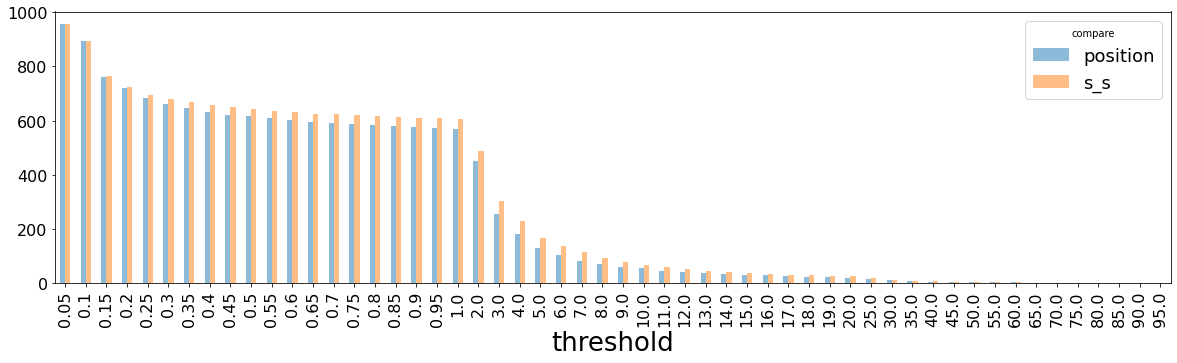

In [150]:
df = pd.read_csv("./output/new_designed1-D/statistics_all.csv", index_col=0)


df_state = df[(df['compare']=="position") | (df['compare']=="s_s") | (df['compare']=="s_s_keep")]

df_pos = df[(df['compare']=="position")]
df_ss = df[(df['compare']=="s_s")]
df_sskeep = df[(df['compare']=="s_s_keep")]



grouped = df_state.groupby(["compare","threshold"]).agg([np.mean, np.std])
grouped = grouped["updates"]

yerr = grouped["std"].unstack().T.to_numpy()
grouped["mean"].unstack().T.plot(kind='bar', alpha=0.5, error_kw=dict(ecolor='k'), figsize=(20,5))
#grouped["mean"].unstack().T

#df[['mean1', 'mean2']].plot(kind='bar', yerr=yerr, alpha=0.5, error_kw=dict(ecolor='k'))
#plt.show()

In [ ]:
# ===========

In [394]:
scenario = "random2-D"

directory = "./output/fixed-{}/s_sk/0".format(scenario)
df = parse_statistics(directory, position=True)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/fixed-{}/s_s_clear/0".format(scenario)
df = parse_statistics(directory, position=True)
df["compare"] = "s_s"
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/fixed-{}/s_s_keep/0".format(scenario)
df = parse_statistics(directory, position=True)
df["compare"] = "s_s_keep"
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

base_dir = "./output/fixed-{}/".format(scenario)
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df=df.rename(columns = {'threshold':'frequency'})
df.to_csv(os.path.join(base_dir, out_file_name))

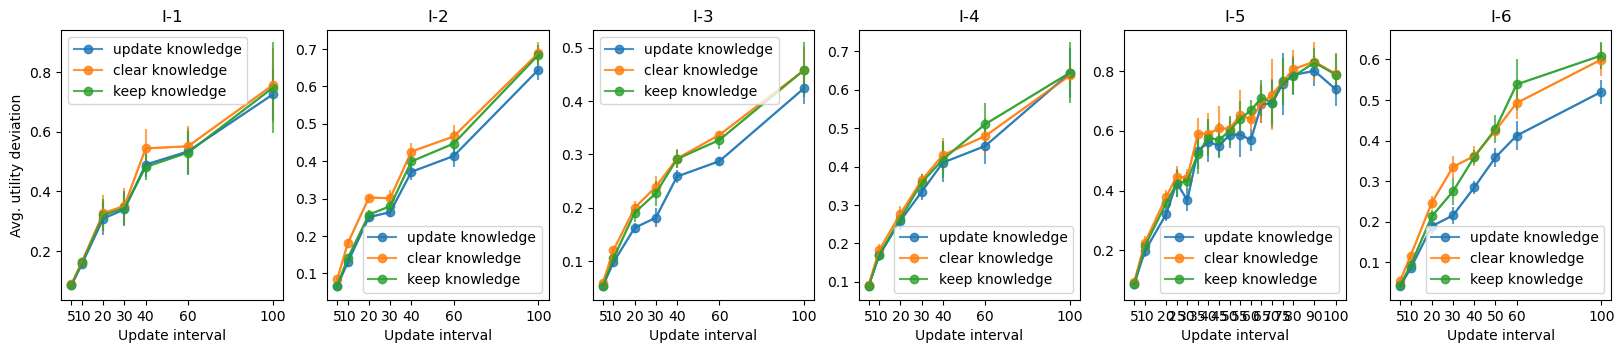

In [395]:
scenarios = ["designed1-D", "designed2-D", "designed3-D", 
            "random1-D", "random2-D", "random3-D"]

params = {'legend.fontsize': '12',
                     'axes.labelsize': '26',
                     'xtick.labelsize':'16',
                     'ytick.labelsize':'16'}
plt.rcParams.update(params)
plt.rcParams.update(plt.rcParamsDefault)
figure, axes = plt.subplots(1, 6, figsize=(20,3.5))


i = 0
for scenario in scenarios:
    df = pd.read_csv("./output/fixed-{}/statistics_all.csv".format(scenario), index_col=0)
    df['updates']=df['updates']/1000
    df['utility']=df['utility']/max_util["new_{}".format(scenario)]

    df_state = df[(df['compare']=="position") | (df['compare']=="s_s") | (df['compare']=="s_s_keep")]
    df_state = df_state[df_state["frequency"] >4]

    grouped = df_state.groupby(["compare","frequency"]).agg([np.mean, np.std])
    grouped = grouped["utility"]


    yerr = grouped["std"].unstack().to_numpy()
    grouped["mean"].unstack().T.plot(alpha=0.7,yerr=yerr, legend=False, ax=axes[i])
    #reset color cycle so that the marker colors match
    axes[i].set_prop_cycle(None)
    #plot the markers
    grouped["mean"].unstack().T.plot(
        style='o-', 
        #xlabel="Update interval", ylabel="Avg. utility deviation", 
        alpha=0.8, ax=axes[i])
    if i == 0:
        axes[i].set_ylabel("Avg. utility deviation")
    axes[i].set_xlabel("Update interval")
    axes[i].legend(["update knowledge", "clear knowledge", "keep knowledge"]);
    axes[i].set_xticks(grouped["mean"].unstack().columns)
    axes[i].set_title("I-{}".format(i+1))
    i = i + 1
#figure.savefig('fig/knowledge_update.pdf',bbox_inches = "tight")



In [372]:
grouped["mean"].unstack().columns

Int64Index([5, 10, 20, 30, 40, 60, 100], dtype='int64', name='frequency')

In [404]:

directory = "./output/1test/s_sk_off10/0"
df = parse_statistics(directory, position=True)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/1test/clear_off10/0"
df = parse_statistics(directory, position=True)
df["compare"] = "s_s"
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

directory = "./output/1test/keep_off10/0"
df = parse_statistics(directory, position=True)
df["compare"] = "s_s_keep"
df.to_csv(os.path.join(directory, "statistics_raw.csv"))

base_dir = "./output/1test/"
out_file_name = "statistics_all.csv"
df = concat_all_statistics(base_dir, "statistics_raw.csv")
df=df.rename(columns = {'threshold':'frequency'})
df.to_csv(os.path.join(base_dir, out_file_name))

compare    position      s_s  s_s_keep
frequency                             
5           0.01024  0.01105   0.01035
10          0.02304  0.02632   0.02495
20          0.03737  0.04402   0.04167
25          0.04962  0.05206   0.04934
30          0.04280  0.05159   0.05038
35          0.06200  0.06876   0.06095
40          0.06553  0.06876   0.06726
45          0.06406  0.07078   0.06625
50          0.06834  0.07073   0.06998
55          0.06840  0.07602   0.07457
60          0.06626  0.07440   0.07782
65          0.08014  0.08050   0.08269
70          0.08064  0.08394   0.08087
75          0.08808  0.08886   0.08914
80          0.09162  0.09386   0.09105
90          0.09322  0.09686   0.09646
100         0.08607  0.09203   0.09180
compare    position       s_s  s_s_keep
frequency                              
5          0.001406  0.001509  0.001435
10         0.002529  0.002533  0.002773
20         0.002494  0.002758  0.001540
25         0.005376  0.004203  0.005071
30         0.004364

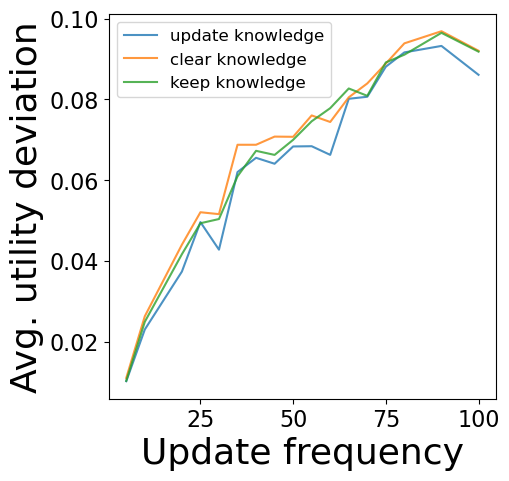

In [403]:
df = pd.read_csv("./output/fixed-random2-D/statistics_all.csv", index_col=0)
df['updates']=df['updates']/1000
#df['utility']=df['utility']/max_util["new_random2-D"]

df_state = df[(df['compare']=="position") | (df['compare']=="s_s") | (df['compare']=="s_s_keep")]
df_state = df_state[df_state["frequency"] >4]

grouped = df_state.groupby(["compare","frequency"]).agg([np.mean, np.std])
grouped = grouped["utility"]

params = {'legend.fontsize': '12',
                 'axes.labelsize': '26',
                 'xtick.labelsize':'16',
                 'ytick.labelsize':'16'}
plt.rcParams.update(params)

yerr = grouped["std"].unstack().T.to_numpy()
fig = grouped["mean"].unstack().T.plot(
    style='-', xlabel="Update frequency", ylabel="Avg. utility deviation", 
    alpha=0.8, figsize=(5,5)).get_figure()
plt.legend(["update knowledge", "clear knowledge", "keep knowledge"]);

fig.savefig('fig/{}.pdf'.format("r1-D-k-update"),bbox_inches = "tight")
print(grouped["mean"].unstack().T)
print(grouped["std"].unstack().T)

In [456]:

def parse_statistics_v2(directory: str, average_window=None):
    import yaml
    """
    The directory tree should be like:
        - directory/
        |---2021-12-12--23-26-49/
           |---statistics/
              |---distances_utility.csv
           |---trace/
              |---parameters.yaml
        |---2021-12-12--23-27-06
        |---2021-12-12--23-27-23
        |---...
        
    :param directory: the root directory
    """
    subdirs = sorted([f.path for f in os.scandir(directory) if f.is_dir()])

    dicts = []
    for subdir in subdirs:
        # get mean utility deviation
        path_util = os.path.join(subdir, "statistics", "distances_utility.csv")
        df = pd.read_csv(path_util,header=None, names=["time","deviation"])
        
        if average_window is not None:
            mean_utility = df["deviation"].head(average_window).mean()
        else:
            mean_utility = df["deviation"].mean()


        # get the configuration parameters
        path_params = os.path.join(subdir, "trace", "parameters.yaml")
        with open(path_params, 'r') as f:
            params = yaml.safe_load(f)
        
        data_row = {
                    'update_mode': params['update_mode'],
                    'utility':     mean_utility,
                    'seed':        params['seed'],
                    'human_seed':  params['human_seed'],
                    'init_time':   params['init_time'],
                    'update_time': params['update_time'],
                    'duration':    params['duration'],
                   }
        dicts.append(data_row)
    return pd.DataFrame(dicts)



In [704]:
# collect all data and store in files
scenarios = ["no_update_designed3-D"]# "designed1-D","designed2-D", "designed3-D", "random1-D", "random2-D", "random3-D"]

average_window = 50

for sc in scenarios:
    try:
        directory = "./output/knowledge_update/{}/".format(sc)
        df = parse_statistics_v2(directory, average_window=average_window)
        df.to_csv(os.path.join(directory, "statistics_raw_{}.csv".format(average_window)))
    except Exception as e:
        print(e)


In [705]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# scale the data

# data without update 
sc = "designed3-D"
directory1 = "./output/knowledge_update/no_update_{}/statistics_raw_{}.csv".format(sc,average_window)
# --read and drop two columns, 
#   here human_seed does not make any difference 
#   because estimation is not involved in "-D" scenarios
df1 = pd.read_csv(directory1, index_col=0).drop(["update_mode","human_seed"], axis=1)
df1 = df1.rename(columns={"utility":"utility_max"})

# data with update
directory2 = "./output/knowledge_update/{}/statistics_raw_{}.csv".format(sc,average_window)
df2 = pd.read_csv(directory2, index_col=0)

df_merged = pd.merge(df2, df1, how="left", on=["seed", "init_time", "update_time", "duration"])

df_merged["utility_scaled"] = df_merged["utility"]/ df_merged["utility_max"]
df_merged.to_csv("./output/knowledge_update/{}/statistics_scaled_{}.csv".format(sc, average_window))


In [661]:
df1

update_mode  utility   seed  human_seed  init_time  update_time  \
0    keep_knowledge    0.036   1111          60          6           56   
1    keep_knowledge    0.084   2222          60          6           56   
2    keep_knowledge    0.054   4444          60          6           56   
3    keep_knowledge    0.096   5555          60          6           56   
4    keep_knowledge    0.050   6666          60          6           56   
..              ...      ...    ...         ...        ...          ...   
895             xxx    0.086   7777          60        828          878   
896             xxx    0.080   8888          60        828          878   
897             xxx    0.094   9999          60        828          878   
898             xxx    0.082  12345          60        828          878   
899             xxx    0.080  67890          60        828          878   

     duration  
0         100  
1         100  
2         100  
3         100  
4         100  
..        ...  
895       100  
896       100  
897       100  
898       100  
899       100  

[900 rows x 7 columns]

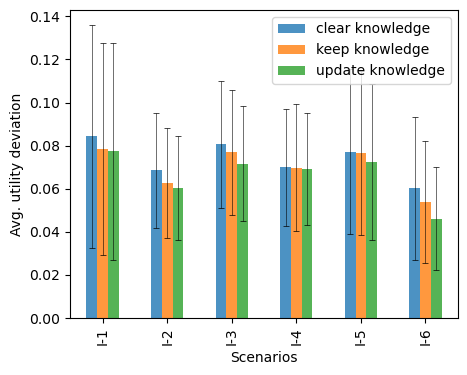

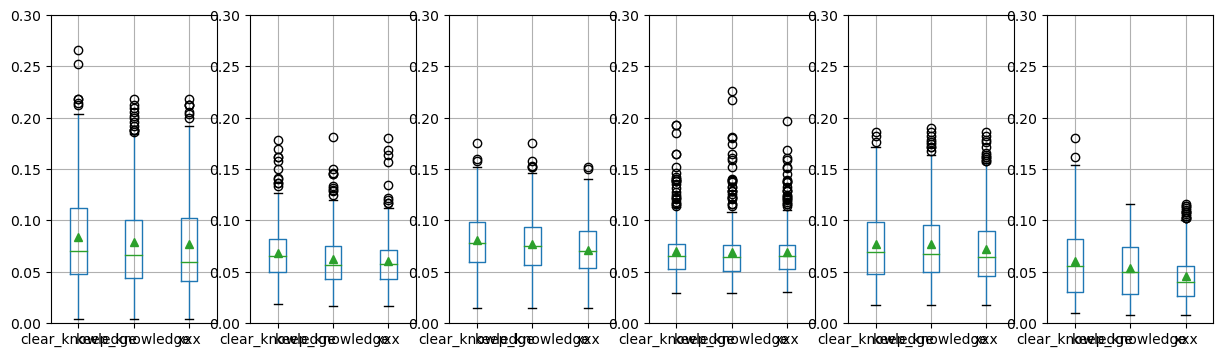

In [117]:
# read from data 
# https://pythonforundergradengineers.com/python-matplotlib-error-bars.html

plt.rcParams.update(plt.rcParamsDefault)
figure, ax = plt.subplots(1, 1, figsize=(5,4))

scenarios = ["designed1-D","designed2-D","designed3-D",'random1-D','random2-D', 'random3-D']
scenarios_labels = ["I-1","I-2","I-3", "I-4", "I-5", "I-6"]
average_window = 50

means = []
stds = []

fig2, ax2 = plt.subplots(1, len(scenarios), figsize=(15,4))
i = 0
for sc in scenarios:
    directory = "./output/knowledge_update/{}/statistics_raw_{}.csv".format(sc,average_window)
    df = pd.read_csv(directory)
    
    dd = []
    names = []
    
    for name, gg in df.groupby(["update_mode"]):
        dd.append(gg["utility"].reset_index().drop("index", axis=1).rename({"utility":name}, axis=1))
        names.append(name)
    pd.concat(dd, axis=1).boxplot(column=names, ax=ax2[i],showmeans=True)
    ax2[i].set_ylim([0,0.3])
    i = i + 1
    
    #grouped = df.groupby(["update_mode","update_time"]).agg([np.mean, np.std])
    #grouped = grouped["utility"]
    #grouped["mean"].unstack()
    grouped = df.groupby(["update_mode"]).agg([np.mean, np.std])["utility"]
    grouped.index.name = None

    means.append(grouped["mean"])
    stds.append(grouped["std"])
    #print(pd.DataFrame(grouped["mean"]).T)
    
    #yerr = grouped["std"]
    #print(yerr)


df_means = pd.concat(means, axis=1, keys=scenarios)
df_stds = pd.concat(stds, axis=1, keys=scenarios)

df_means.T.plot(kind='bar', align='center',alpha=0.8, ax=ax, 
                yerr=df_stds.T, error_kw=dict(lw=0.4, capsize=2, capthick=0.5))
ax.legend(["clear knowledge", "keep knowledge", "update knowledge"]);
ax.set_xticklabels(scenarios_labels)

ax.set_ylabel("Avg. utility deviation")
ax.set_xlabel("Scenarios")

figure.savefig('fig/knowledge_update_v2_{}.pdf'.format(average_window),bbox_inches = "tight")


update_mode  clear_knowledge  keep_knowledge     xxx
update_time                                         
56                    0.0742          0.0782  0.0500
94                    0.0914          0.0946  0.0942
144                   0.0262          0.0278  0.0274
149                   0.0304          0.0304  0.0304
154                   0.0316          0.0316  0.0316
209                   0.0286          0.0260  0.0260
213                   0.0298          0.0226  0.0250
270                   0.0824          0.0340  0.0340
275                   0.0502          0.0538  0.0538
320                   0.0922          0.0626  0.0440
334                   0.1078          0.0728  0.0564
394                   0.0772          0.0640  0.0568
398                   0.0658          0.0654  0.0572
402                   0.0570          0.0578  0.0358
417                   0.0914          0.0878  0.0380
439                   0.0420          0.0418  0.0370
479                   0.0872          0.0702  0.0550
482                   0.0730          0.0580  0.0558
509                   0.0598          0.0436  0.0412
520                   0.0710          0.0614  0.0620
653                   0.0650          0.0716  0.0592
668                   0.0934          0.0900  0.0900
764                   0.0354          0.0354  0.0354
797                   0.0576          0.0712  0.0704
827                   0.0612          0.0468  0.0450
831                   0.0454          0.0734  0.0420
875                   0.0246          0.0246  0.0246
876                   0.0230          0.0230  0.0230
878                   0.0246          0.0246  0.0246

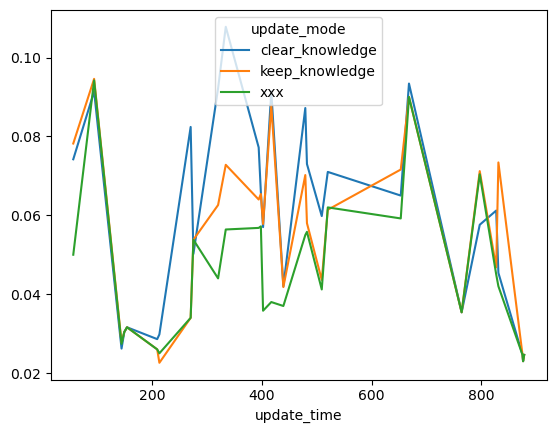

In [722]:
directory = "./output/knowledge_update/random3-D/statistics_raw_50.csv"
df = pd.read_csv(directory)

grouped = df.groupby(["update_mode","update_time"]).agg([np.mean, np.std])
grouped = grouped["utility"]
grouped["mean"].unstack().T.plot()
grouped["mean"].unstack().T

#grouped = df.groupby(["update_mode"]).agg([np.mean, np.std])["utility"]
#grouped.index.name = None

#print(pd.DataFrame(grouped["mean"]).T)

#yerr = grouped["std"]
#print(yerr)


In [7]:
import yaml
from src.runner.Loader import TraceLoader
import src.runner.Loader as Loader
from collections import Counter

def parse_utility(trace_path, k, out_path=None):

    loader = TraceLoader(trace_path)
    traces = loader.read_trace()
    comparator = Comparator()
    utility = [_calc_k_coverage_value(k, state) for state in traces]
    time = [state["time"] for state in traces]
    
    df = pd.DataFrame([time,utility]).T
    df.columns = ["time", "utility"]
    
    if out_path is not None:
        df.to_csv(out_path, index=False)
    return df


##### Copied from Comparator.py
def _calc_k_coverage_value(k, state):
    num_objs = Loader.get_num_objs(state)
    return len(_filter_k_coverage(k, state)) / float(num_objs)

def _filter_k_coverage(k, state):
    assert k >= 0
    coverage = _calc_cov_for_objs(state)
    return {key: v for key, v in coverage.items() if v >= k}

def _calc_cov_for_objs(state):
    """
    :param state:
    :return: a dict, indicating which object (id) has been covered by how many cameras
    {'objID': coverage}
    """
    cov_objs = []
    for cam in state["cameras"].values():
        obj_list = cam["objects"]
        cov_objs += obj_list
    return dict(Counter(cov_objs))




In [858]:
# export utility to files

directory_base = "./output/knowledge_update/for_line_plot/random3-D"

#fig, ax = plt.subplots(1, 1, figsize=(5,4))

subdirs = sorted([f.path for f in os.scandir(directory_base) if f.is_dir()])

data = {}
for subdir in subdirs:
    path_trace = os.path.join(subdir, "trace", "output_main.txt")
    out_path_utility = os.path.join(subdir, "statistics", "utility.csv")    
    parse_utility(path_trace, k=2, out_path=out_path_utility)



SyntaxError: unmatched ')' (3540405958.py, line 17)

In [859]:
# parse real trace to get utility
path_trace = "./output/knowledge_update/for_line_plot/test_random3-D-3333.txt"
out_path_utility = "./output/knowledge_update/for_line_plot/utility_random3-D.csv"    
parse_utility(path_trace, k=2, out_path=out_path_utility)

time  utility
0       1.0      0.4
1       2.0      0.4
2       3.0      0.2
3       4.0      0.4
4       5.0      0.5
..      ...      ...
995   996.0      0.1
996   997.0      0.1
997   998.0      0.1
998   999.0      0.1
999  1000.0      0.1

[1000 rows x 2 columns]

Text(0.5, 0, 'Time')

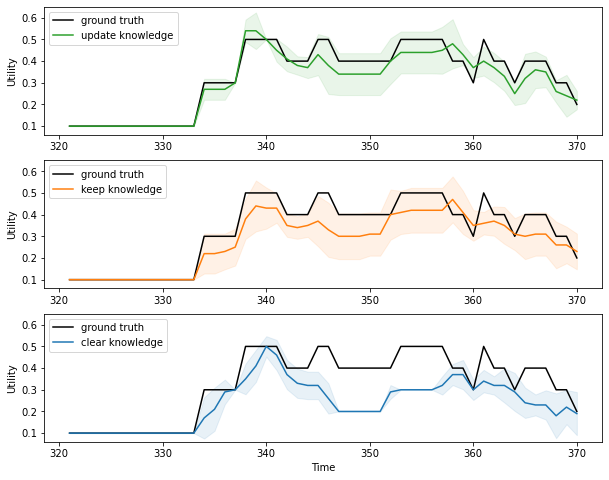

In [42]:
# read and plot utility
label = {"keep_knowledge":"keep knowledge",
         "clear_knowledge":"clear knowledge",
         "xxx":"update knowledge",
        }

color = {"keep_knowledge":"tab:orange",
         "clear_knowledge":"tab:blue",
         "xxx":"tab:green",
        }
    

directory_base = "./output/knowledge_update/for_line_plot/random3-D"

# ----------  
# Load data
# ----------  
path_real = "./output/knowledge_update/for_line_plot/utility_random3-D.csv"
df = pd.read_csv(path_real, index_col=0)


subdirs = sorted([f.path for f in os.scandir(directory_base) if f.is_dir()])
data = {}
for subdir in subdirs:
    path_utility = os.path.join(subdir, "statistics", "utility.csv")
    path_config = os.path.join(subdir, "trace", "parameters.yaml")

    df = pd.read_csv(path_utility, index_col=0)

    with open(path_config, 'r') as f:
        params = yaml.safe_load(f)
        if params["update_mode"] in data:
            data[params["update_mode"]].append(df)
        else:
            data[params["update_mode"]] = [df]

data_d = {k: pd.concat(v, axis=1) for k, v in data.items()}

# ----------  
# Plot
# ----------  
fig, ax = plt.subplots(3, 1, figsize=(10,8))
i = 0
for k, item in sorted(data_d.items(), reverse=True):

    data_sliced = item.loc[params['update_time']+1:params['update_time']+50] # = 320

    
    data_mean = data_sliced.mean(axis=1)
    data_std = data_sliced.std(axis=1)

    # plot ground truth
    df.loc[params['update_time']+1: params['update_time']+50].plot(color="black",ax=ax[i])
    # plot mean
    data_sliced.mean(axis=1).plot(ax=ax[i], color=color[k])
    # plot deviation
    ax[i].fill_between(data_sliced.index, data_mean - data_std, data_mean + data_std, alpha=0.1, color=color[k])    
    ax[i].legend(["ground truth",label[k]], loc='upper left')
    ax[i].set_ylabel("Utility")
    ax[i].set_ylim([0.06,0.65])
    ax[i].set_xlabel("")
    i = i + 1
ax[-1].set_xlabel("Time")

fig.savefig('fig/knowledge_update_line_r3-D.pdf', bbox_inches = "tight")

#data_d["keep_knowledge"].plot(color="b", ax=ax)
#data_d["clear_knowledge"].plot(color="r", ax=ax)
#data_d["xxx"].plot(color="g", ax=ax)

#ax.set_xlim([0,500])

In [751]:
from src.runner.Loader import TraceLoader
import src.runner.Loader



memory_list = []
scenario_list = ["designed1","designed2","designed3","random1","random2","random3"]
for scenario in scenario_list:
    loader = TraceLoader("./src/simulator/traces_real/test_{}-D-3333.txt".format(scenario))
    traces = loader.read_trace()
    obj_count = src.runner.Loader.get_num_objs(traces[0])
    cam_count = len(traces[0]['cameras'])
    cov_obj_counts = [obj_count - len(state['objects']) for state in traces]
    
    memory = {"action": 999*cam_count*4, # one variable per camera,  int: 4 bytes
             "state": (999*cam_count + sum(cov_obj_counts))*(2*8), 
              # positions of cameras and covered objects, 
              # each entity has two variables {x, y},  double: 8 bytes
             "knowledge": 999*cam_count*(cam_count-1)/2 * 8} 
            # each edge has one variable,  double: 8 bytes
    memory_list.append(memory)
    print('------------')
    print(scenario, "objs", obj_count, "cams", cam_count)
    print("state:\t\t", memory['state'], "bytes")
    print("action:\t\t", memory['action'], "bytes")
    print("knowledge:\t", memory['knowledge'], "bytes")

df_memory = pd.DataFrame(memory_list, index=scenario_list)

KeyError: '3'

compare    position      s_s  s_s_keep
frequency                             
5           0.01192  0.01222   0.01196
10          0.02273  0.02456   0.02292
20          0.03480  0.03720   0.03553
30          0.04486  0.04890   0.04807
60          0.06091  0.06438   0.06853
100         0.08645  0.08560   0.08654

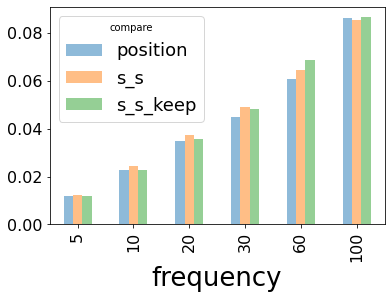

In [222]:
df = pd.read_csv("./output/random1-D-fixed/statistics_all.csv", index_col=0)

df_state = df[(df['compare']=="position") | (df['compare']=="s_s") | (df['compare']=="s_s_keep")]


grouped = df_state.groupby(["compare","frequency"]).agg([np.mean, np.std])
grouped = grouped["utility"]

yerr = grouped["std"].unstack().T.to_numpy()
grouped["mean"].unstack().T.plot(kind='bar', alpha=0.5, error_kw=dict(ecolor='k'))
grouped["mean"].unstack().T

action_direct		: 0.8542490339201375
action_direct_v2		: 0.8454873336195792
interaction		: 0.9295165306998714
position		: 0.9306891369686559
s_s		: 0.926644482610563
Figure saved to fig/r2-D-update-K-or-not.pdf


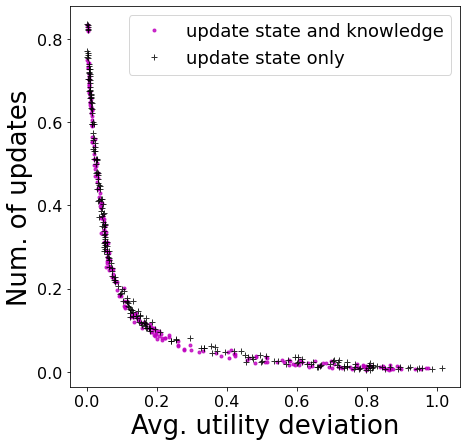

In [21]:

df = pd.read_csv("./output/new_random2-D/statistics_all.csv", index_col=0)
df['updates']=df['updates']/1000
df['utility']=df['utility']/max_util["new_random2-D"]
calc_hypervolumes(df, ref_point=[1,1])


my_plot(df, 
        "r2-D-update-K-or-not", ["position", "s_s"],
        label_names = ["update state and knowledge","update state only"],
        save_fig=True,
        params = {'legend.fontsize': '18',
             'axes.labelsize': '26',
             'xtick.labelsize':'16',
             'ytick.labelsize':'16'}
       )



action		: 0.7443219335515776
action_direct		: 0.904416451904994
action_direct_v2		: 0.912788813819043
action_v2		: 0.36026119662882217
interaction		: 0.9639338301873651
position		: 0.9512205196071611
s_s		: 0.9484379048547757
Figure saved to fig/d1-D-update-K-or-not.pdf


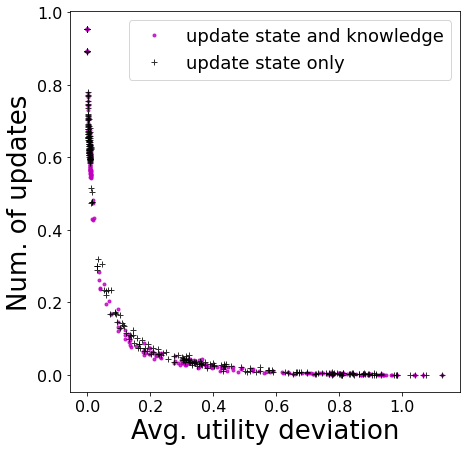

In [141]:

df = pd.read_csv("./output/new_designed1-D/statistics_all.csv", index_col=0)
df['updates']=df['updates']/1000
df['utility']=df['utility']/max_util["new_designed1-D"]
calc_hypervolumes(df, ref_point=[1,1])

my_plot(df, 
        "d1-D-update-K-or-not", ["position", "s_s"],
        label_names = ["update state and knowledge","update state only"],
        save_fig=True,
        params = {'legend.fontsize': '18',
             'axes.labelsize': '26',
             'xtick.labelsize':'16',
             'ytick.labelsize':'16'}
       )



In [150]:
directory = "./output/new_designed1-D-4444/action_v2/1"

df = parse_statistics(directory)
df["compare"] = "action_v2"
df.to_csv(os.path.join(directory, "statistics_raw.csv"))
df

compare threshold human_seed  updates  utility
0  action_v2      0.05        100       13   0.0916
1  action_v2      0.15        100       13   0.0916
2  action_v2      0.25        100        1   0.1097
3  action_v2      0.35        100        1   0.1097
4  action_v2      0.45        100        0   0.1217
5  action_v2      0.55        100        0   0.1217
6  action_v2      0.65        100        0   0.1217
7  action_v2      0.75        100        0   0.1217
8  action_v2      0.85        100        0   0.1217
9  action_v2      0.95        100        0   0.1217

In [147]:
directory = "./output/new_designed1-D-4444/action/1234"

df = parse_statistics(directory)
df.to_csv(os.path.join(directory, "statistics_raw.csv"))
df

compare threshold human_seed  updates  utility
0   action      0.05        100       53   0.0552
1   action       0.1        100       29   0.0726
2   action      0.15        100       23   0.0818
3   action       0.2        100        9   0.0973
4   action      0.25        100        8   0.0897
5   action       0.3        100        3   0.0932
6   action      0.35        100        2   0.0928
7   action       0.4        100        0   0.1217
8   action      0.45        100        0   0.1217
9   action       0.5        100        0   0.1217
10  action      0.55        100        0   0.1217
11  action       0.6        100        0   0.1217
12  action      0.65        100        0   0.1217
13  action       0.7        100        0   0.1217
14  action      0.75        100        0   0.1217
15  action       0.8        100        0   0.1217
16  action      0.85        100        0   0.1217
17  action       0.9        100        0   0.1217
18  action      0.95        100        0   0.1217
19  action      0.01        100       77   0.0336
20  action      0.02        100       77   0.0336
21  action      0.03        100       77   0.0336
22  action      0.04        100       77   0.0336
23  action      0.06        100       53   0.0552
24  action      0.07        100       53   0.0552
25  action      0.08        100       52   0.0638
26  action      0.09        100       52   0.0638
27  action       0.1        100       29   0.0726
28  action      0.11        100       29   0.0726
29  action      0.12        100       29   0.0726
30  action      0.13        100       29   0.0726
31  action      0.14        100       29   0.0726
32  action      0.16        100       23   0.0818
33  action      0.17        100       23   0.0818
34  action      0.18        100       23   0.0818
35  action      0.19        100       23   0.0818
36  action     0.191        100       23   0.0818
37  action     0.192        100       23   0.0818
38  action     0.193        100       23   0.0818
39  action     0.194        100       23   0.0818
40  action     0.195        100       23   0.0818
41  action     0.196        100       23   0.0818
42  action     0.197        100       23   0.0818
43  action     0.198        100       23   0.0818
44  action     0.199        100       23   0.0818
45  action      0.23        100        9   0.0973
46  action      0.26        100        8   0.0897
47  action      0.29        100        8   0.0897
48  action      0.32        100        3   0.0932
49  action      0.35        100        2   0.0928
50  action      0.38        100        2   0.0928
51  action      0.41        100        0   0.1217
52  action      0.44        100        0   0.1217
53  action      0.47        100        0   0.1217

In [9]:
# just for test, we actually do not need to get the mean
df.groupby('threshold').mean().reset_index() 

threshold  updates  utility
0       0.1    807.2  0.00346
1       0.2    268.8  0.02697
2       0.3     19.8  0.05857
3       0.4      5.6  0.09333
4       0.5      1.2  0.10582
5       0.6      0.0  0.11444
6       0.7      0.0  0.11444
7       0.8      0.0  0.11444
8       0.9      0.0  0.11444

In [ ]:
## Check the correlation when no update is applied

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # 打印所有结果

def calc_correlation(real_path, pre_path, action_path=None):
    # calculate other metrics (interaction, action, position, etc.) for the trace
    import sys
    sys.path.append('./src/runner')
    import Loader
    from Comparator import Comparator
    import numpy as np
    import pandas as pd
    from scipy import stats
    
    # load real trace
    traces_real = Loader.TraceLoader(real_path).read_trace()
    time_real_list = [state["time"] for state in traces_real]
    
    # load prediction trace
    traces_pre = Loader.TraceLoader(pre_path).read_trace()

    # get distance metrics
    dists_pos = Comparator("position").compare(traces_pre, traces_real)[:-1]
    dists_int = Comparator("interaction").compare(traces_pre, traces_real)[:-1]
    dists_util = Comparator("utility").compare(traces_pre, traces_real)[:-1]
    if action_path is None:
        dists_act = Comparator("action").compare(traces_pre, traces_real)[:-1]
    else:
        tmp_df = pd.read_csv(action_path, header=None, names=["act"], index_col=0)
        dists_act = [0.0] + list(tmp_df["act"])
    
    df = pd.DataFrame({
        "pos": dists_pos,
        "int": dists_int,
        "act": dists_act,
        "util": dists_util
    }, index=time_real_list[:-1])

    # scale the data
    df_scaled = df/df.max()
    
    # plot
    df_scaled.plot(figsize=(25,5))
    pd.plotting.scatter_matrix(df_scaled, figsize=(8,8), alpha=0.4)
    print(df_scaled.corr(method="spearman"))

           pos       int       act      util
pos   1.000000  0.402930  0.342243 -0.000177
int   0.402930  1.000000  0.523337  0.120229
act   0.342243  0.523337  1.000000 -0.140315
util -0.000177  0.120229 -0.140315  1.000000
           pos       int       act      util
pos   1.000000  0.402930  0.289418 -0.000177
int   0.402930  1.000000  0.459959  0.120229
act   0.289418  0.459959  1.000000  0.360817
util -0.000177  0.120229  0.360817  1.000000


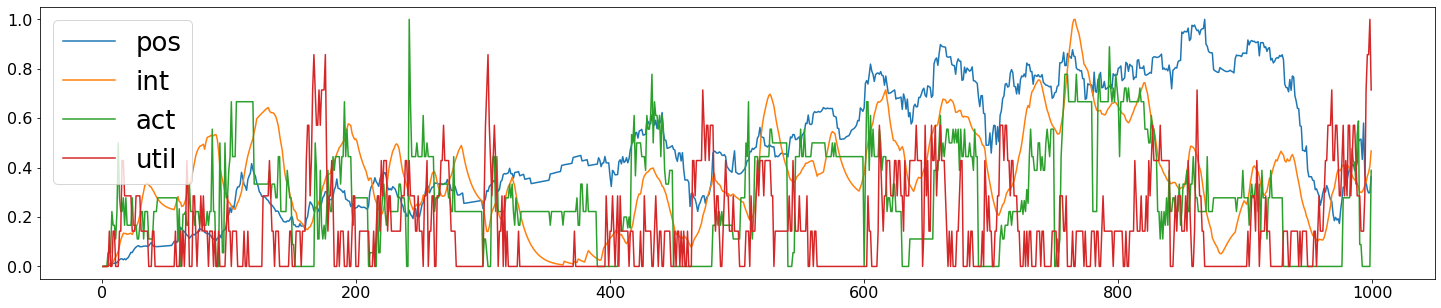

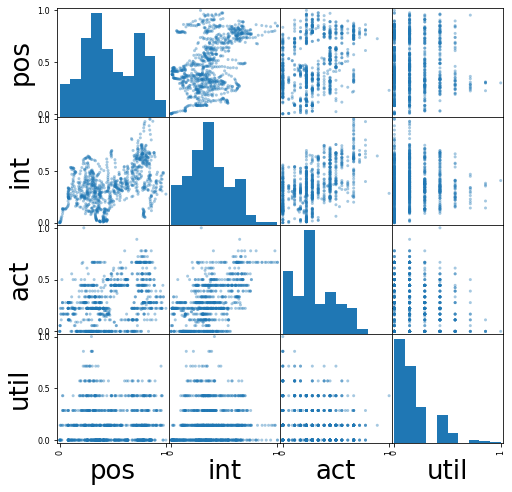

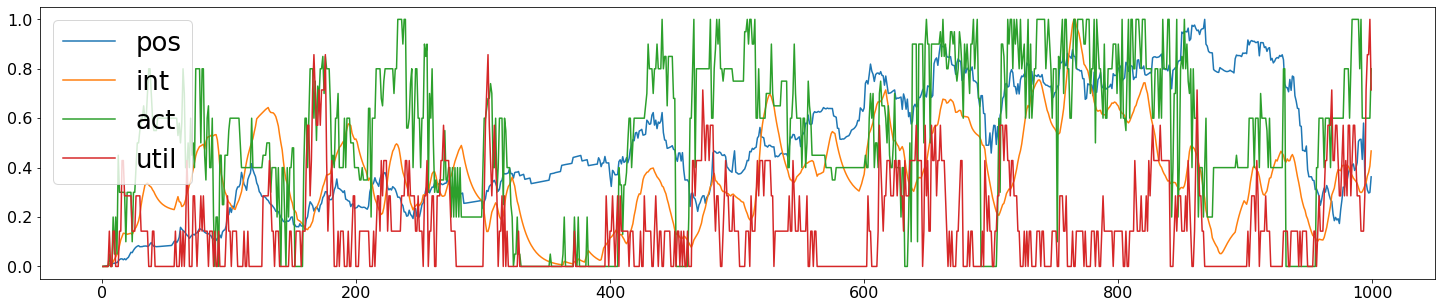

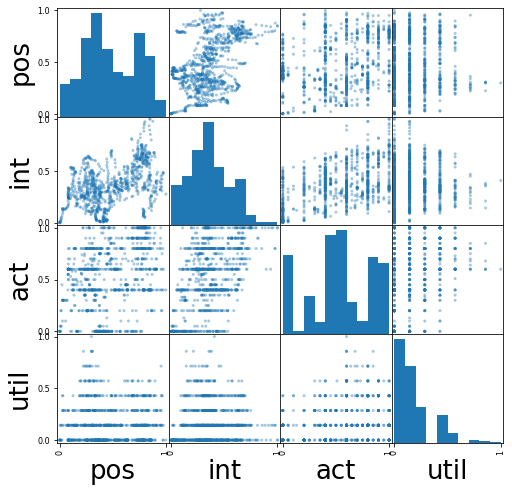

In [64]:
# designed1v2-D  
real_path = "./src/simulator/traces_real/trace_designed1v2_10o_5c-D.txt"
pre_path = "./output/designed1v2-D/action/1/2021-12-13--20-00-58/trace/output_main.txt"
action_path = "./output/designed1v2-D/action/1/2021-12-13--20-00-58/statistics/distances_action.csv" 

calc_correlation(real_path, pre_path, action_path)
calc_correlation(real_path, pre_path)

           pos       int       act      util
pos   1.000000  0.722463 -0.173647  0.538480
int   0.722463  1.000000 -0.026758  0.598558
act  -0.173647 -0.026758  1.000000 -0.142352
util  0.538480  0.598558 -0.142352  1.000000
           pos       int       act      util
pos   1.000000  0.722463  0.625004  0.538480
int   0.722463  1.000000  0.718010  0.598558
act   0.625004  0.718010  1.000000  0.567695
util  0.538480  0.598558  0.567695  1.000000


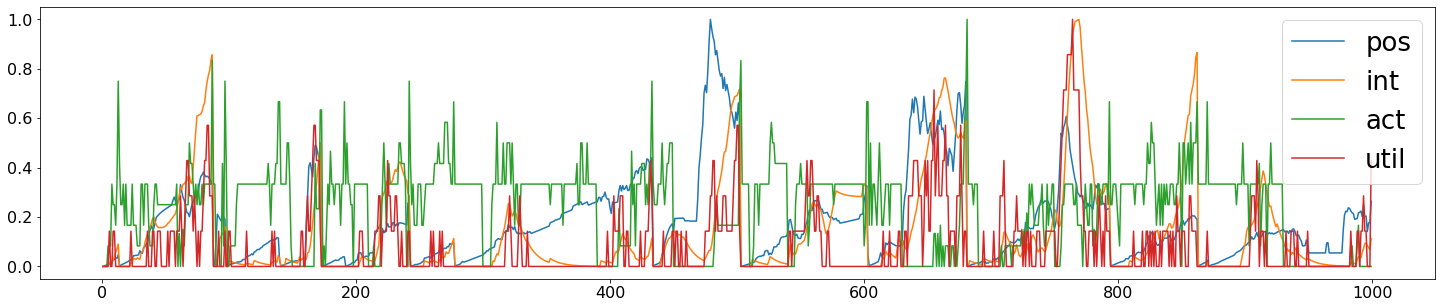

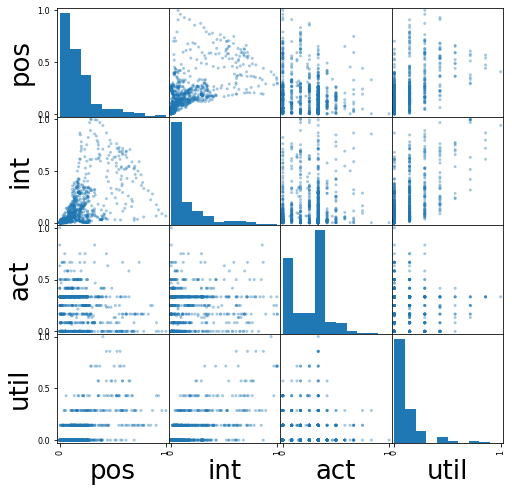

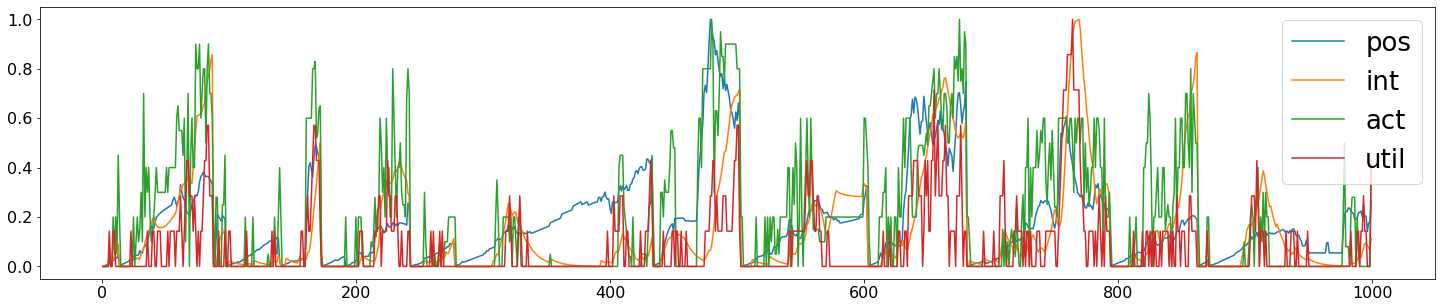

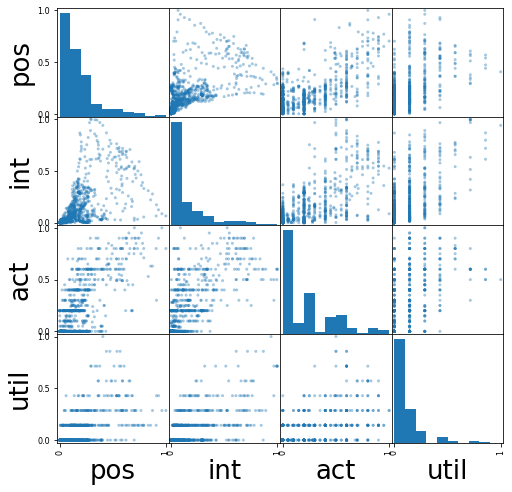

In [65]:

# 有更新的情况下的designed1v2-D
real_path = "./src/simulator/traces_real/trace_designed1v2_10o_5c-D.txt"
pre_path = "./output/designed1v2-D/action/1/2021-12-13--19-59-14/trace/output_main.txt"
action_path = "./output/designed1v2-D/action/1/2021-12-13--19-59-14/statistics/distances_action.csv" 

calc_correlation(real_path, pre_path, action_path)
calc_correlation(real_path, pre_path)

           pos       int       act      util
pos   1.000000  0.399195  0.222800  0.143508
int   0.399195  1.000000  0.017672 -0.087703
act   0.222800  0.017672  1.000000  0.080186
util  0.143508 -0.087703  0.080186  1.000000
           pos       int       act      util
pos   1.000000  0.399195  0.441352  0.143508
int   0.399195  1.000000  0.243351 -0.087703
act   0.441352  0.243351  1.000000  0.130153
util  0.143508 -0.087703  0.130153  1.000000


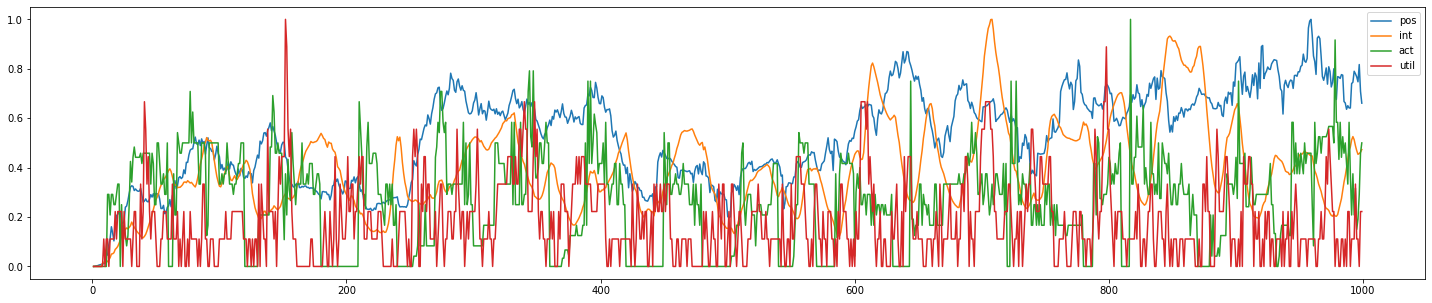

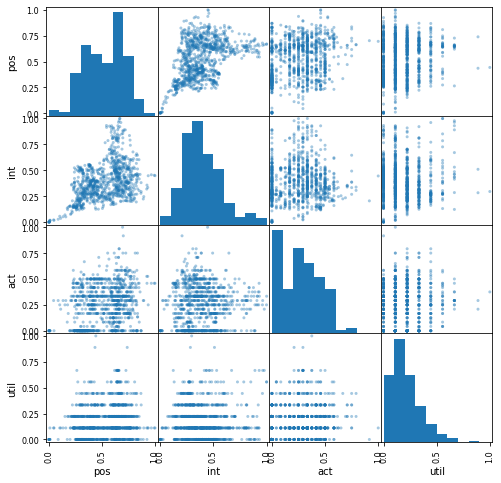

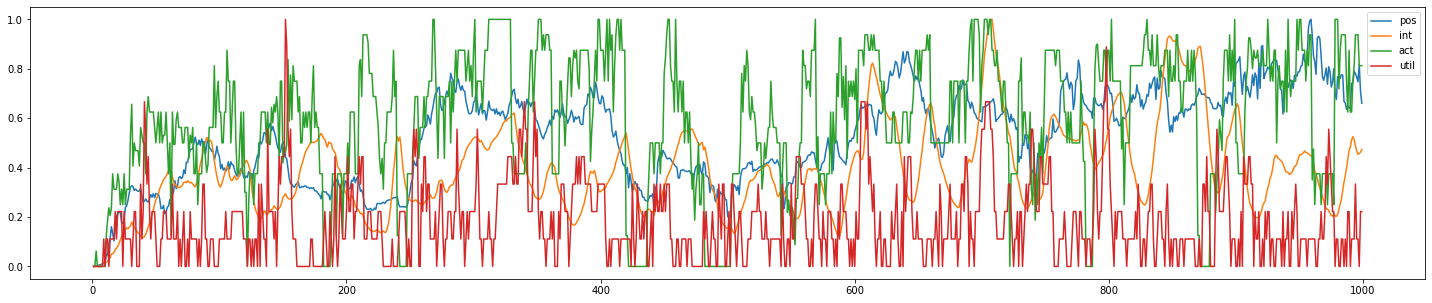

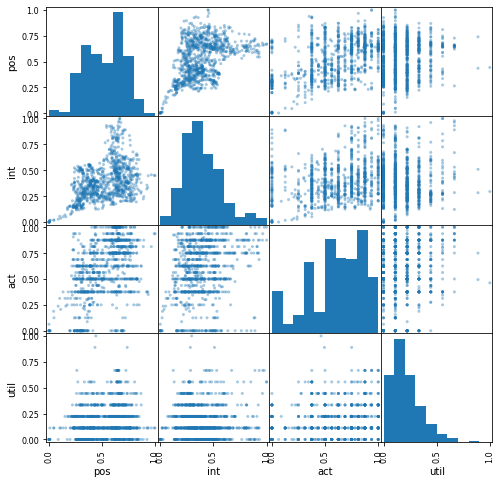

In [124]:
# designed2-D
real_path = "./src/simulator/traces_real/trace_designed2_12o_8c-D.txt"
pre_path = "./output/designed2-D/action/1/2021-12-14--15-59-03-915/trace/output_main.txt"
action_path = "./output/designed2-D/action/1/2021-12-14--15-59-03-915/statistics/distances_action.csv" 
calc_correlation(real_path, pre_path, action_path)
calc_correlation(real_path, pre_path)

           pos       int       act      util
pos   1.000000  0.770789  0.216697  0.451728
int   0.770789  1.000000  0.179248  0.329318
act   0.216697  0.179248  1.000000  0.000559
util  0.451728  0.329318  0.000559  1.000000
           pos       int       act      util
pos   1.000000  0.770789  0.667679  0.451728
int   0.770789  1.000000  0.553567  0.329318
act   0.667679  0.553567  1.000000  0.298741
util  0.451728  0.329318  0.298741  1.000000


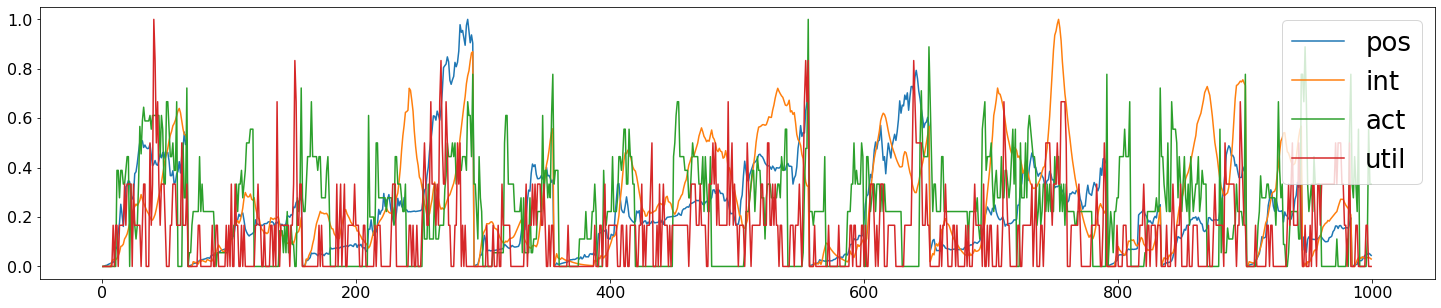

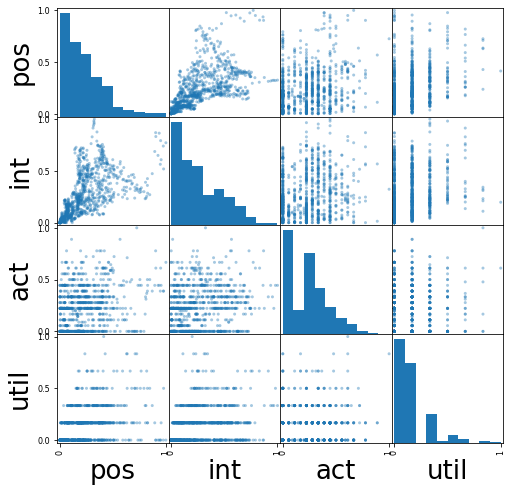

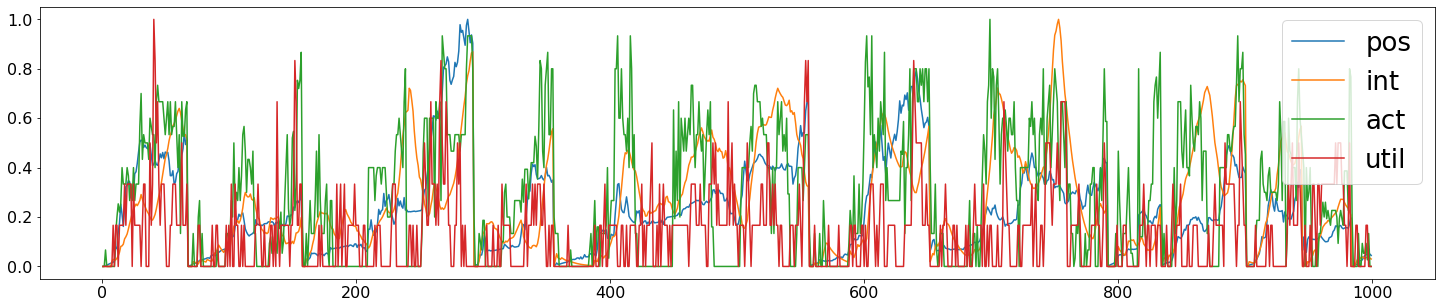

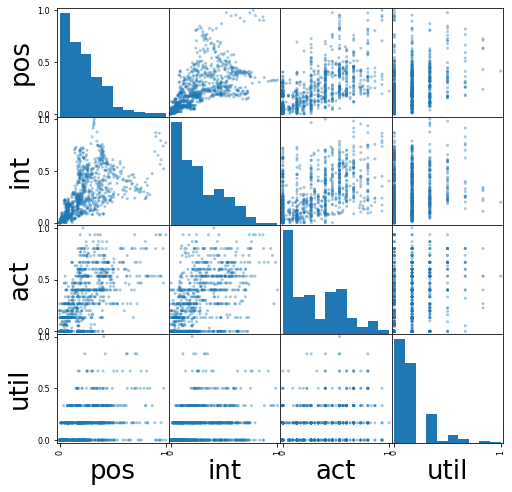

In [60]:
# 有更新的情况下的designed2-D
real_path = "./src/simulator/traces_real/trace_designed2_12o_8c-D.txt"
pre_path = "./output/designed2-D/action_new/1/2021-12-19--22-30-55-479/trace/output_main.txt"
action_path = "./output/designed2-D/action_new/1/2021-12-19--22-30-55-479/statistics/distances_action.csv" 
calc_correlation(real_path, pre_path, action_path)
calc_correlation(real_path, pre_path)

           pos       int       act      util
pos   1.000000  0.511781  0.270139  0.364200
int   0.511781  1.000000  0.078979  0.279589
act   0.270139  0.078979  1.000000  0.030409
util  0.364200  0.279589  0.030409  1.000000
           pos       int       act      util
pos   1.000000  0.511781  0.527669  0.364200
int   0.511781  1.000000  0.594163  0.279589
act   0.527669  0.594163  1.000000  0.331275
util  0.364200  0.279589  0.331275  1.000000


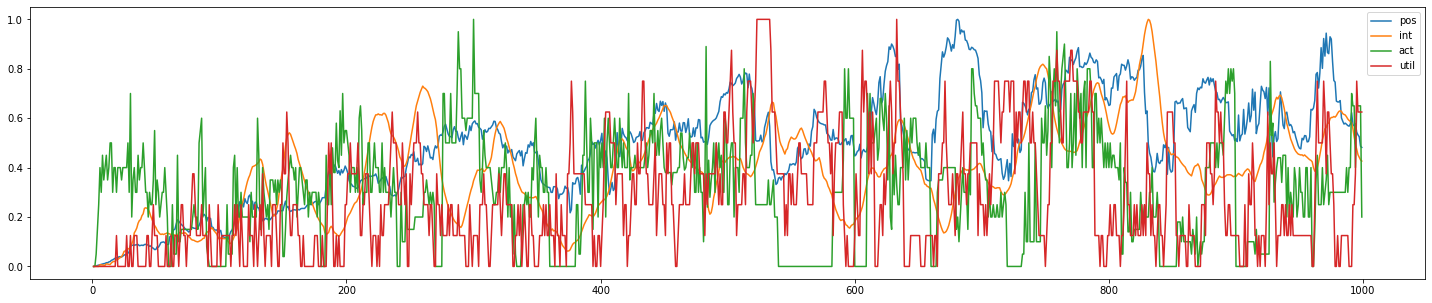

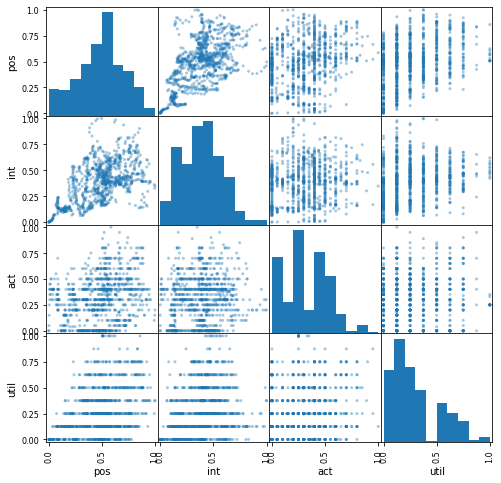

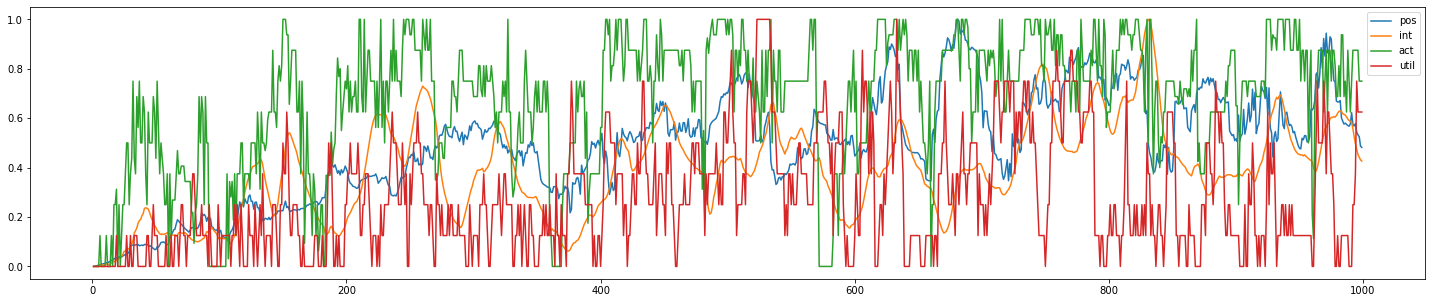

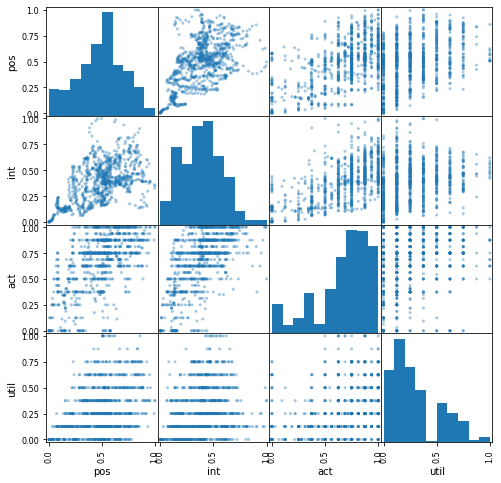

In [125]:
# designed3-D
real_path = "./src/simulator/traces_real/trace_designed3_12o_8c-D.txt"
pre_path = "./output/designed3-D/action/1/2021-12-14--16-51-55-994/trace/output_main.txt"
action_path = "./output/designed3-D/action/1/2021-12-14--16-51-55-994/statistics/distances_action.csv" 

calc_correlation(real_path, pre_path, action_path)
calc_correlation(real_path, pre_path)

           pos       int       act      util
pos   1.000000  0.261700  0.043451  0.156855
int   0.261700  1.000000  0.106479  0.150285
act   0.043451  0.106479  1.000000  0.000387
util  0.156855  0.150285  0.000387  1.000000
           pos       int       act      util
pos   1.000000  0.261700  0.355182  0.156855
int   0.261700  1.000000  0.176720  0.150285
act   0.355182  0.176720  1.000000  0.241481
util  0.156855  0.150285  0.241481  1.000000


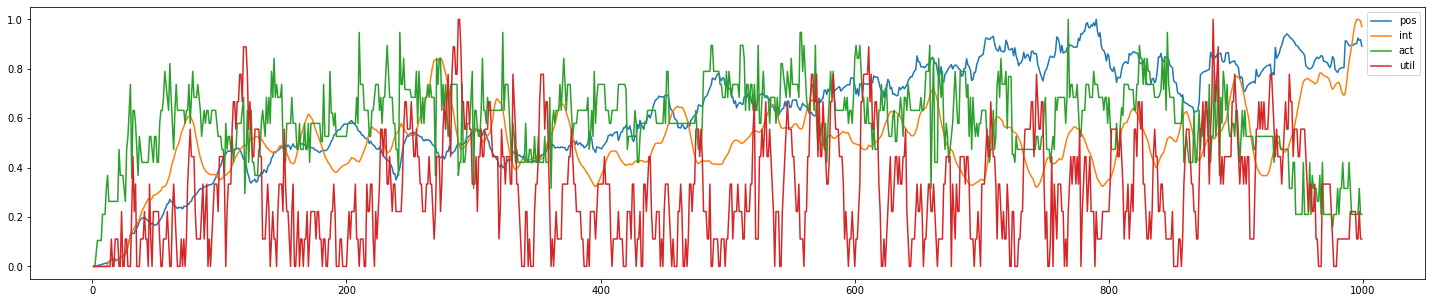

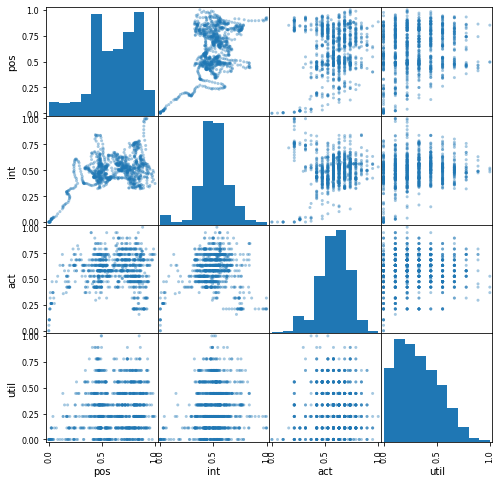

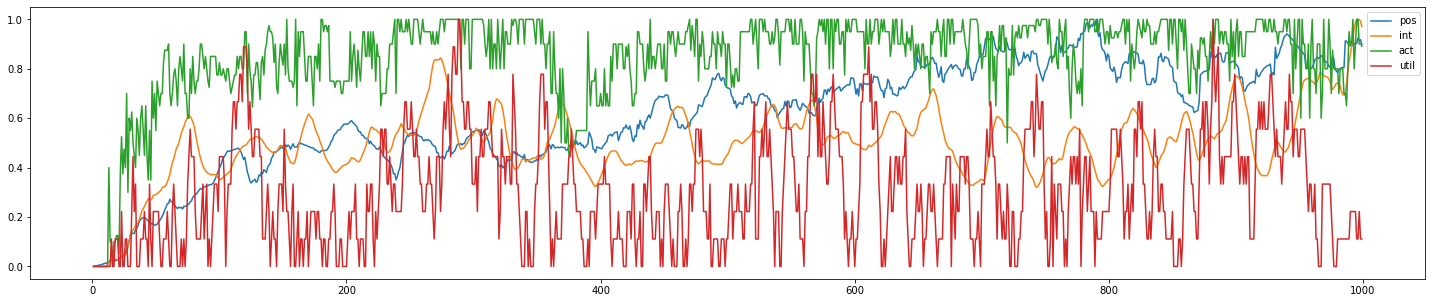

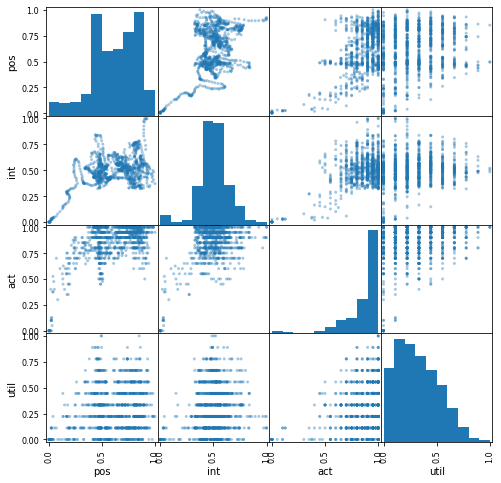

In [132]:
# random1-D
real_path = "./src/simulator/traces_real/trace_random1_20o_10c-D.txt"

pre_dir = "./output/random1-D/action/1/2021-12-14--17-51-40-509"
pre_path = os.path.join(pre_dir, "trace/output_main.txt")
action_path = os.path.join(pre_dir, "statistics/distances_action.csv")

calc_correlation(real_path, pre_path, action_path)
calc_correlation(real_path, pre_path)

           pos       int       act      util
pos   1.000000  0.931864  0.074470  0.471809
int   0.931864  1.000000  0.043788  0.473550
act   0.074470  0.043788  1.000000 -0.028287
util  0.471809  0.473550 -0.028287  1.000000
           pos       int       act      util
pos   1.000000  0.931864  0.788900  0.471809
int   0.931864  1.000000  0.787320  0.473550
act   0.788900  0.787320  1.000000  0.462599
util  0.471809  0.473550  0.462599  1.000000


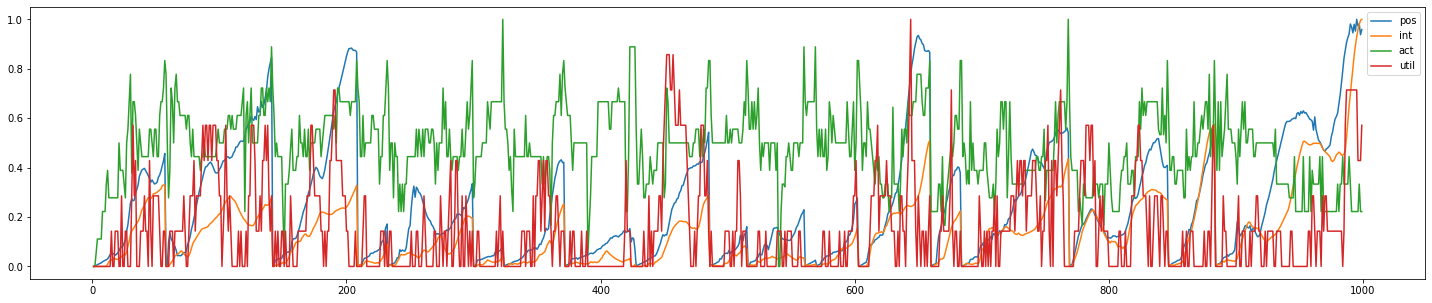

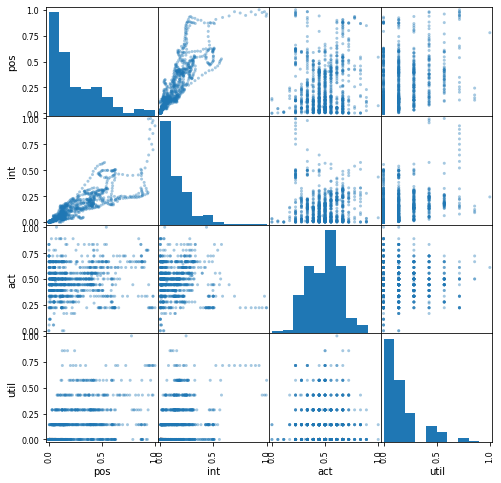

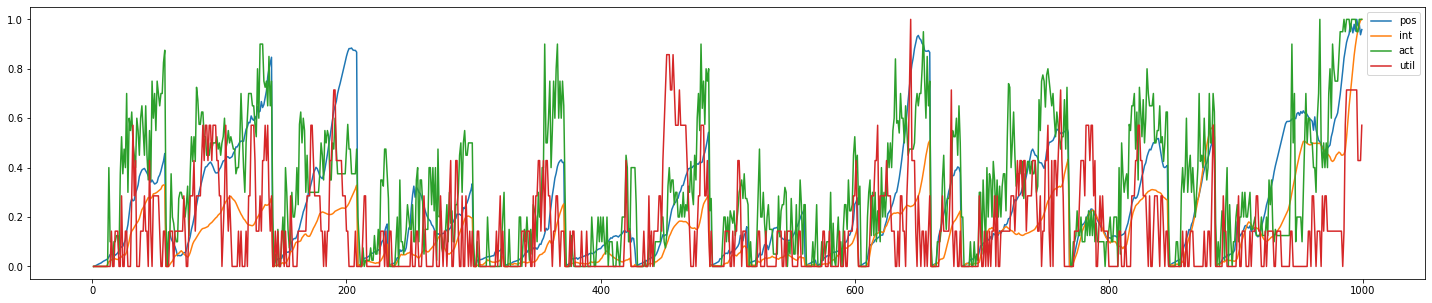

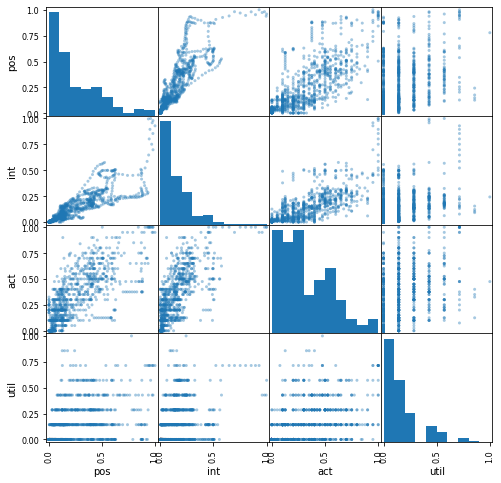

In [134]:
# 当有更新时的random1-D
pre_dir = "./output/random1-D/action/1/2021-12-14--17-49-19-669"
pre_path = os.path.join(pre_dir, "trace/output_main.txt")
action_path = os.path.join(pre_dir, "statistics/distances_action.csv")

calc_correlation(real_path, pre_path, action_path)
calc_correlation(real_path, pre_path)

           pos       int       act      util
pos   1.000000  0.500619  0.294445  0.044801
int   0.500619  1.000000 -0.062024  0.031251
act   0.294445 -0.062024  1.000000  0.025477
util  0.044801  0.031251  0.025477  1.000000
           pos       int       act      util
pos   1.000000  0.500619  0.582841  0.044801
int   0.500619  1.000000  0.305151  0.031251
act   0.582841  0.305151  1.000000  0.094624
util  0.044801  0.031251  0.094624  1.000000


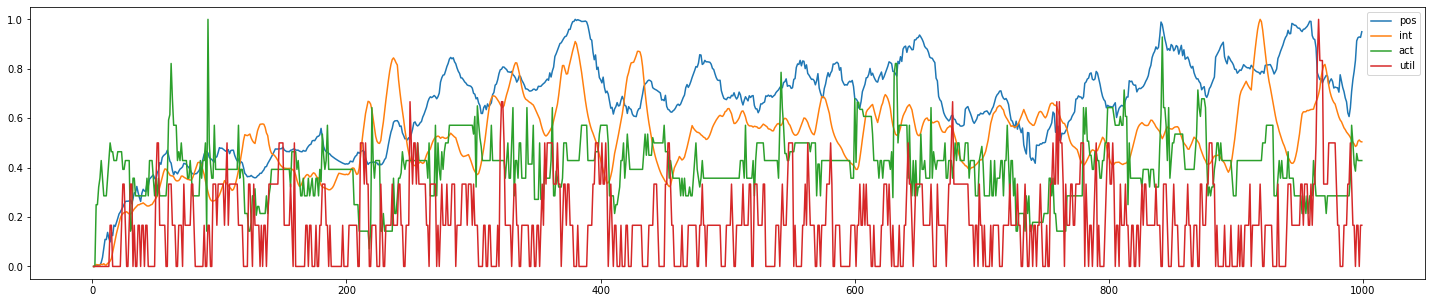

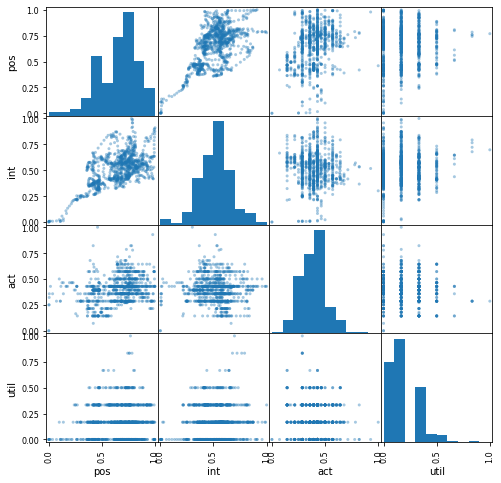

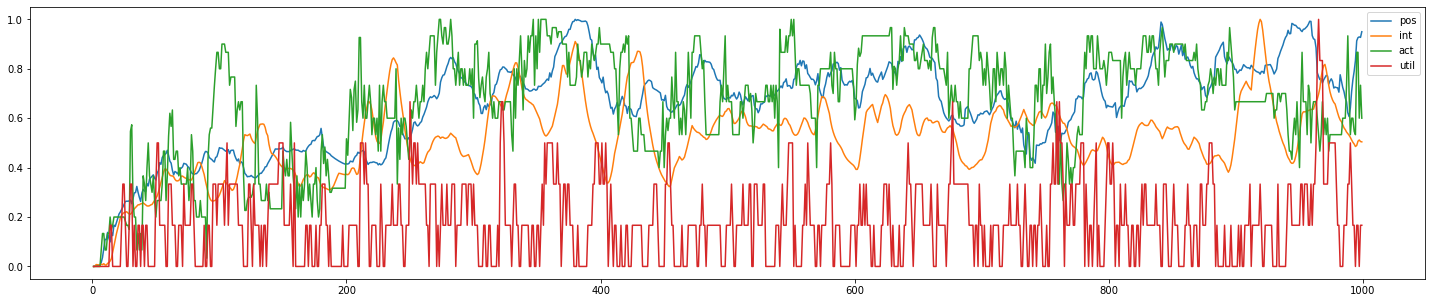

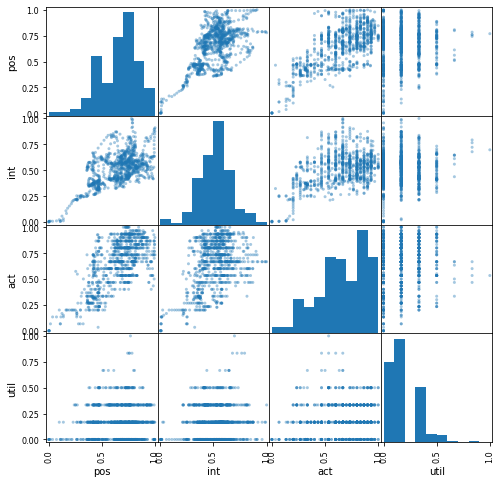

In [131]:
# random2-D
real_path = "./src/simulator/traces_real/trace_random2_10o_15c-D.txt"
pre_path = "./output/random2-D/action/1/2021-12-14--18-16-40-849/trace/output_main.txt"
action_path = "./output/random2-D/action/1/2021-12-14--18-16-40-849/statistics/distances_action.csv" 

calc_correlation(real_path, pre_path, action_path)
calc_correlation(real_path, pre_path)

           pos       int       act      util
pos   1.000000  0.429800 -0.163779  0.096482
int   0.429800  1.000000 -0.103933  0.048715
act  -0.163779 -0.103933  1.000000  0.059273
util  0.096482  0.048715  0.059273  1.000000
           pos       int       act      util
pos   1.000000  0.429800  0.185653  0.096482
int   0.429800  1.000000  0.289702  0.048715
act   0.185653  0.289702  1.000000  0.100192
util  0.096482  0.048715  0.100192  1.000000


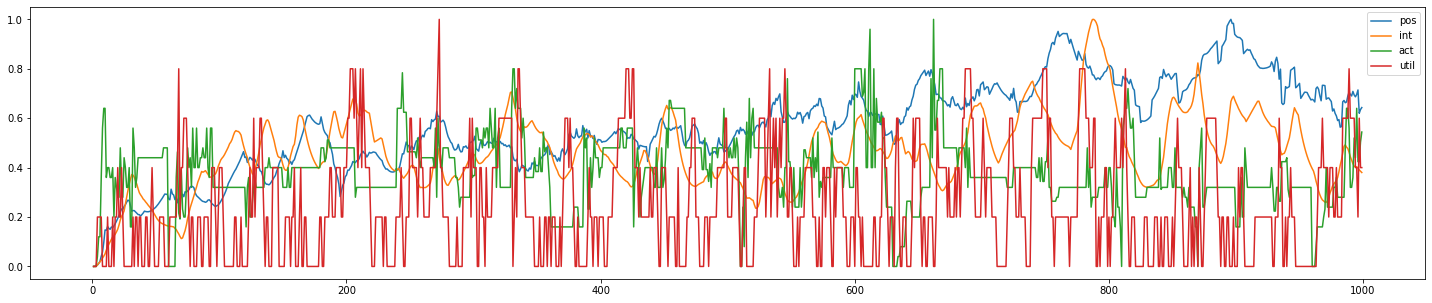

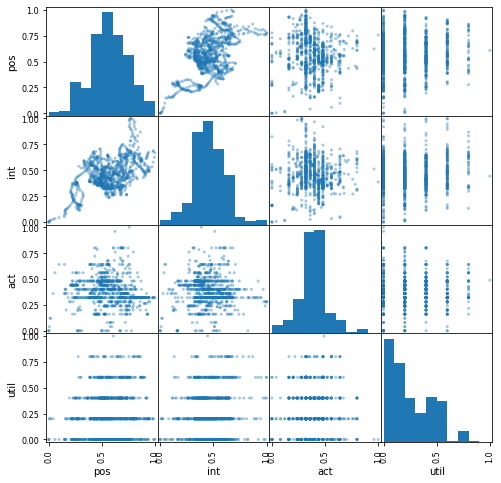

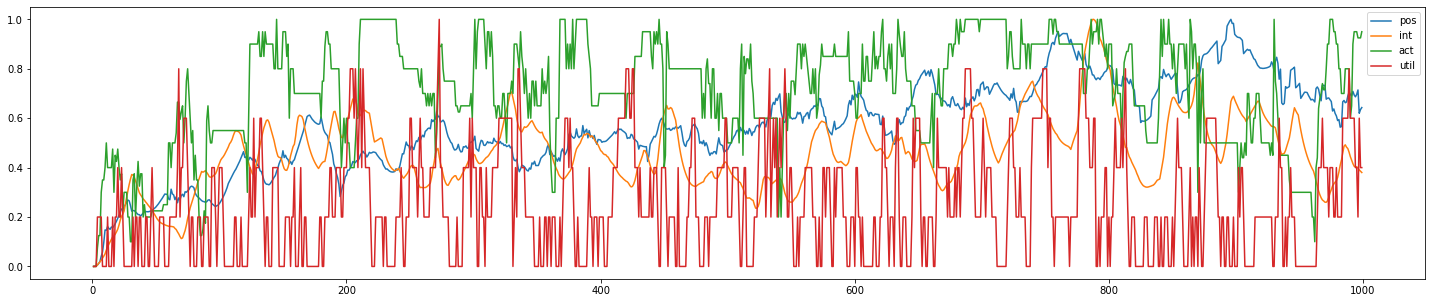

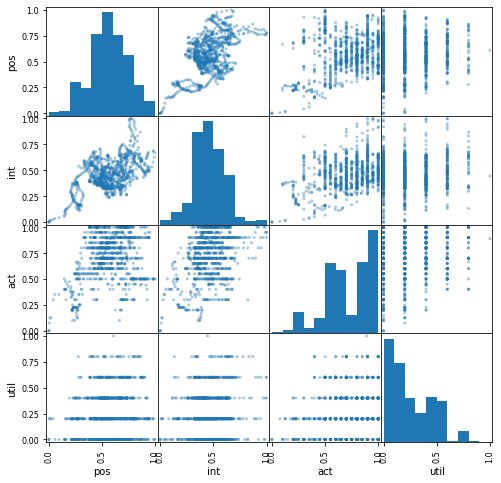

In [128]:
# random3-D
real_path = "./src/simulator/traces_real/trace_random3_10o_10c-D.txt"
pre_path = "./output/random3-D/action/1/2021-12-14--22-07-00-084/trace/output_main.txt"
action_path = "./output/random3-D/action/1/2021-12-14--22-07-00-084/statistics/distances_action.csv" 

calc_correlation(real_path, pre_path, action_path)
calc_correlation(real_path, pre_path)